## Access, preprocess, analyse and visualize satellite images in Google Colab with Python

In [ ]:
!pip install sentinelsat rasterio folium
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes
!apt install gdal-bin python-gdal python3-gdal
!apt install python3-rtree
!pip install cartopy
!pip install metpy
!pip install opencv-python
!pip install GDAL
!apt-get install -y python3-gdal
!pip install rasterio
!pip install remotior_sensus
!pip install rasterio numpy
!pip install openeo


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for html2text: filename=html2text-2024.2.26-py3-none-any.whl size=33111 sha256=a7716383b8013c6c987d8f2899beb80c4ae04ae2d283098df1c952d8f2a995df
  Stored in directory: /root/.cache/pip/wheels/f3/96/6d/a7eba8f80d31cbd188a2787b81514d82fc5ae6943c44777659
Successfully built html2text
  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-71vajjlh
  Running command git clone --filter=blob:none --quiet git://github.com/geopandas/geopandas.git /tmp/pip-req-build-71vajjlh
  fatal: unable to connect to github.com:
  github.com[0: 140.82.114.3]: errno=Connection timed out

  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet git://github.com/geopandas/geopan

In [ ]:
import folium
import os
import numpy as np

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona

import pandas as pd # for data manpulation
import xml.etree.ElementTree as ET

from PIL import Image # library for image processing tasks in Python.
import cv2 #OpenCV is a computer vision library
import subprocess
import xarray as xr  # a library designed for working with labeled multi-dimensional arrays
# Any import of metpy will activate the accessors
from metpy.cbook import get_test_data


In [ ]:
import remotior_sensus
rs = remotior_sensus.Session(n_processes=2, available_ram=10240)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Connection of Api To copernicus dataspace

## Method of How to query CDSE Catalogue and download products

##Import necessary Python modules

In [ ]:
# HTTP requests
import requests

# JSON parser
import json

# XML parser
import xml.etree.ElementTree as ET

# system modules
import os
import re
import sys
import random

# data manipulation
import pandas as pd
import numpy as np

# image manipulation
import rasterio
import matplotlib.pyplot as plt
import matplotlib.image
from rasterio.windows import Window

# file manipulation
from pathlib import Path
import json


import scipy.signal
import openeo

#### Query the catalogue and get a list of products matching the search parameters
Refer to https://documentation.dataspace.copernicus.eu/APIs/OData.html#query-collection-of-products

In [ ]:
# base URL of the product catalogue
catalogue_odata_url = "https://catalogue.dataspace.copernicus.eu/odata/v1"

# search parameters
collection_name = "SENTINEL-2"
product_type = "S2MSI1C"
max_cloud_cover = 0
aoi = "POLYGON((31.697205 31.222998, 31.163132 30.703006, 31.438889 30.512965, 31.97818 31.053455, 31.697205 31.222998))"
 #{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}
search_period_start = "2020-05-10T00:00:00.000Z"
search_period_end = "2021-11-15T00:00:00.000Z"


#### Build and check the search query

In [ ]:
search_query = f"{catalogue_odata_url}/Products?$filter=Collection/Name eq '{collection_name}' and Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/OData.CSC.StringAttribute/Value eq '{product_type}') and OData.CSC.Intersects(area=geography'SRID=4326;{aoi}') and ContentDate/Start gt {search_period_start} and ContentDate/Start lt {search_period_end}"

print(f"""\n{search_query.replace(' ', "%20")}\n""")


https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name%20eq%20'SENTINEL-2'%20and%20Attributes/OData.CSC.StringAttribute/any(att:att/Name%20eq%20'productType'%20and%20att/OData.CSC.StringAttribute/Value%20eq%20'S2MSI1C')%20and%20OData.CSC.Intersects(area=geography'SRID=4326;POLYGON((31.697205%2031.222998,%2031.163132%2030.703006,%2031.438889%2030.512965,%2031.97818%2031.053455,%2031.697205%2031.222998))')%20and%20ContentDate/Start%20gt%202020-05-10T00:00:00.000Z%20and%20ContentDate/Start%20lt%202021-11-15T00:00:00.000Z



In [ ]:
from urllib.parse import quote
import requests

encoded_search_query = quote(search_query, safe='/:?=&')

# Print the encoded search query for inspection
print("Encoded URL:", encoded_search_query)

# Run the query and get the response
response = requests.get(encoded_search_query)

# Check if the request was successful
if response.status_code == 200:
    print(response.json())
else:
    print(f"Failed to retrieve data, status code: {response.status_code}")
    print("Response content:", response.text)  # This line will print the error message from the server


Encoded URL: https://catalogue.dataspace.copernicus.eu/odata/v1/Products?%24filter=Collection/Name%20eq%20%27SENTINEL-2%27%20and%20Attributes/OData.CSC.StringAttribute/any%28att:att/Name%20eq%20%27productType%27%20and%20att/OData.CSC.StringAttribute/Value%20eq%20%27S2MSI1C%27%29%20and%20OData.CSC.Intersects%28area=geography%27SRID=4326%3BPOLYGON%28%2831.697205%2031.222998%2C%2031.163132%2030.703006%2C%2031.438889%2030.512965%2C%2031.97818%2031.053455%2C%2031.697205%2031.222998%29%29%27%29%20and%20ContentDate/Start%20gt%202020-05-10T00:00:00.000Z%20and%20ContentDate/Start%20lt%202021-11-15T00:00:00.000Z
{'@odata.context': '$metadata#Products', 'value': [{'@odata.mediaContentType': 'application/octet-stream', 'Id': '0a193977-57aa-52a9-bc8c-adfb6cf41037', 'Name': 'S2A_MSIL1C_20211102T084121_N0301_R064_T36RUU_20211102T093243.SAFE', 'ContentType': 'application/octet-stream', 'ContentLength': 0, 'OriginDate': '2021-11-02T11:29:11.077Z', 'PublicationDate': '2021-11-03T12:02:22.817Z', 'Modific

#### Run the query and display the results

In [ ]:
response = requests.get(search_query).json()
result = pd.DataFrame.from_dict(response["value"])


result.head()

,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,application/octet-stream,17215086-9f32-5008-a99c-c90544936e47,S2B_MSIL1C_20211104T083029_N0500_R021_T36RVV_2...,application/octet-stream,795048364,2023-01-26T23:23:34.142Z,2023-01-30T10:10:52.892Z,2024-02-23T21:09:25.218Z,True,,/eodata/Sentinel-2/MSI/L1C_N0500/2021/11/04/S2...,"[{'Value': '2f516218664d84747ab0c2fe0e93cd62',...","{'Start': '2021-11-04T08:30:29.024Z', 'End': '...",geography'SRID=4326;POLYGON ((31.9451030140255...,"{'type': 'Polygon', 'coordinates': [[[31.94510..."
1,application/octet-stream,9c0c14e1-dd41-5282-9a52-13ccf954a318,S2B_MSIL1C_20210720T083559_N0301_R064_T36RUU_2...,application/octet-stream,0,2021-07-23T20:11:35.079Z,2021-07-20T12:48:58.570Z,2021-07-20T12:48:58.570Z,True,,/eodata/Sentinel-2/MSI/L1C/2021/07/20/S2B_MSIL...,[],"{'Start': '2021-07-20T08:35:59.024Z', 'End': '...",geography'SRID=4326;POLYGON ((31.259792242733 ...,"{'type': 'Polygon', 'coordinates': [[[31.25979..."
2,application/octet-stream,c7f6e656-34d8-5f33-826c-aa7b7bc8aae2,S2B_MSIL1C_20210720T083559_N0301_R064_T36RUV_2...,application/octet-stream,0,2021-07-20T12:48:56.263Z,2021-07-20T12:57:37.984Z,2021-07-20T12:57:37.984Z,True,,/eodata/Sentinel-2/MSI/L1C/2021/07/20/S2B_MSIL...,[],"{'Start': '2021-07-20T08:35:59.024Z', 'End': '...",geography'SRID=4326;POLYGON ((31.525843919623 ...,"{'type': 'Polygon', 'coordinates': [[[31.52584..."
3,application/octet-stream,ce517721-5697-40ef-aa91-703da55989f8,S2B_MSIL1C_20210707T082609_N0500_R021_T36RVV_2...,application/octet-stream,851309943,2023-03-16T03:28:03.811Z,2023-03-16T04:35:15.179Z,2024-02-29T22:22:39.423Z,True,,/eodata/Sentinel-2/MSI/L1C_N0500/2021/07/07/S2...,"[{'Value': '3132883583fed5f89bb3559ea9660857',...","{'Start': '2021-07-07T08:26:09.024Z', 'End': '...",geography'SRID=4326;POLYGON ((31.9451030140255...,"{'type': 'Polygon', 'coordinates': [[[31.94510..."
4,application/octet-stream,a8c70db3-cf93-4542-9d1c-2f93f7075d3a,S2B_MSIL1C_20210707T082609_N0500_R021_T36RUU_2...,application/octet-stream,870642313,2023-03-16T03:27:19.614Z,2023-03-16T04:29:40.426Z,2024-02-29T22:23:14.063Z,True,,/eodata/Sentinel-2/MSI/L1C_N0500/2021/07/07/S2...,"[{'Value': '87dbade7305abb3815f64944cb1b791e',...","{'Start': '2021-07-07T08:26:09.024Z', 'End': '...",geography'SRID=4326;POLYGON ((30.9113966287438...,"{'type': 'Polygon', 'coordinates': [[[30.91139..."


#### Add filtering by cloud coverage and repeat the query

In [ ]:
search_query = f"{search_query} and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value le {max_cloud_cover})"
print(f"""\n{search_query.replace(' ', "%20")}\n""")

response = requests.get(search_query).json()
result = pd.DataFrame.from_dict(response["value"])


result



https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name%20eq%20'SENTINEL-2'%20and%20Attributes/OData.CSC.StringAttribute/any(att:att/Name%20eq%20'productType'%20and%20att/OData.CSC.StringAttribute/Value%20eq%20'S2MSI1C')%20and%20OData.CSC.Intersects(area=geography'SRID=4326;POLYGON((31.697205%2031.222998,%2031.163132%2030.703006,%2031.438889%2030.512965,%2031.97818%2031.053455,%2031.697205%2031.222998))')%20and%20ContentDate/Start%20gt%202020-05-10T00:00:00.000Z%20and%20ContentDate/Start%20lt%202021-11-15T00:00:00.000Z%20and%20Attributes/OData.CSC.DoubleAttribute/any(att:att/Name%20eq%20'cloudCover'%20and%20att/OData.CSC.DoubleAttribute/Value%20le%200)



,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,application/octet-stream,bff6df04-8e8a-4639-979f-06fa354c5594,S2A_MSIL1C_20201005T082821_N0500_R021_T36RUU_2...,application/octet-stream,874208346,2023-08-10T08:49:06.181Z,2023-08-10T09:13:29.648Z,2023-08-10T09:13:44.782Z,True,,/eodata/Sentinel-2/MSI/L1C_N0500/2020/10/05/S2...,"[{'Value': 'ae4716c06ab56b1a9cfa380ff8234b60',...","{'Start': '2020-10-05T08:28:21.024Z', 'End': '...",geography'SRID=4326;POLYGON ((30.9113966287438...,"{'type': 'Polygon', 'coordinates': [[[30.91139..."
1,application/octet-stream,3c25bdc2-f734-4ec3-b4f8-fe922b006ab7,S2A_MSIL1C_20201025T083031_N0500_R021_T36RUU_2...,application/octet-stream,884456474,2023-08-09T21:14:57.865Z,2023-08-09T21:29:20.328Z,2023-08-09T21:29:33.012Z,True,,/eodata/Sentinel-2/MSI/L1C_N0500/2020/10/25/S2...,"[{'Value': '1b0238eb6c3ed17fbb5fbe576d32bf4e',...","{'Start': '2020-10-25T08:30:31.024Z', 'End': '...",geography'SRID=4326;POLYGON ((30.9113966287438...,"{'type': 'Polygon', 'coordinates': [[[30.91139..."
2,application/octet-stream,967264e8-54a7-4669-940a-26ee155ecd5a,S2A_MSIL1C_20201018T083951_N0500_R064_T36RUV_2...,application/octet-stream,386918342,2023-08-12T21:59:22.341Z,2023-08-12T22:07:18.063Z,2023-08-12T22:07:25.192Z,True,,/eodata/Sentinel-2/MSI/L1C_N0500/2020/10/18/S2...,"[{'Value': 'ec95fb9da2c33cdc11aafff8c4a5ca32',...","{'Start': '2020-10-18T08:39:51.024Z', 'End': '...",geography'SRID=4326;POLYGON ((31.5221629908435...,"{'type': 'Polygon', 'coordinates': [[[31.52216..."
3,application/octet-stream,82ae7a51-ffc0-4547-b4ae-a37f70e9f8ee,S2A_MSIL1C_20201018T083951_N0500_R064_T36RUU_2...,application/octet-stream,189029625,2023-08-12T21:54:54.721Z,2023-08-12T22:08:23.674Z,2023-08-12T22:08:34.316Z,True,,/eodata/Sentinel-2/MSI/L1C_N0500/2020/10/18/S2...,"[{'Value': 'e5038e96c56de94289ccb364eccf6ccd',...","{'Start': '2020-10-18T08:39:51.024Z', 'End': '...",geography'SRID=4326;POLYGON ((31.259899732119 ...,"{'type': 'Polygon', 'coordinates': [[[31.25989..."
4,application/octet-stream,8f0bd9de-79e7-4784-8e61-81bd6a05fa99,S2B_MSIL1C_20201013T083829_N0500_R064_T36RUU_2...,application/octet-stream,148768717,2023-08-13T18:54:11.148Z,2023-08-13T19:05:00.417Z,2023-08-13T19:05:06.971Z,True,,/eodata/Sentinel-2/MSI/L1C_N0500/2020/10/13/S2...,"[{'Value': 'fa562b6d413546ce9b76065cd658c2a3',...","{'Start': '2020-10-13T08:38:29.024Z', 'End': '...",geography'SRID=4326;POLYGON ((31.0578257437524...,"{'type': 'Polygon', 'coordinates': [[[31.05782..."
5,application/octet-stream,d2b7c660-ecbf-461e-b5f8-a0cc36a079c6,S2B_MSIL1C_20201020T082909_N0500_R021_T36RUV_2...,application/octet-stream,833824260,2023-08-13T23:55:39.631Z,2023-08-14T00:05:22.559Z,2023-08-14T00:05:33.479Z,True,,/eodata/Sentinel-2/MSI/L1C_N0500/2020/10/20/S2...,"[{'Value': 'acb239ea9ac194d9bab764e1226b0525',...","{'Start': '2020-10-20T08:29:09.024Z', 'End': '...",geography'SRID=4326;POLYGON ((30.8915059675555...,"{'type': 'Polygon', 'coordinates': [[[30.89150..."
6,application/octet-stream,3f660d6a-ed68-4de3-bf8f-87aa115c3685,S2B_MSIL1C_20201023T083929_N0500_R064_T36RUU_2...,application/octet-stream,176551871,2023-08-20T11:20:21.205Z,2023-08-20T11:28:48.770Z,2023-08-20T11:28:54.480Z,True,,/eodata/Sentinel-2/MSI/L1C_N0500/2020/10/23/S2...,"[{'Value': '5bcbfd55ecc797d55d255c0b53ef691a',...","{'Start': '2020-10-23T08:39:29.024Z', 'End': '...",geography'SRID=4326;POLYGON ((31.264339866388 ...,"{'type': 'Polygon', 'coordinates': [[[31.26433..."
7,application/octet-stream,b04c9c7d-aa1a-5892-8c28-54a0fb0a8c71,S2A_MSIL1C_20201018T083951_N0209_R064_T36RUV_2...,application/octet-stream,0,2020-10-18T13:32:16.447Z,2020-10-18T13:39:10.117Z,2020-10-18T13:39:10.117Z,True,,/eodata/Sentinel-2/MSI/L1C/2020/10/18/S2A_MSIL...,[],"{'Start': '2020-10-18T08:39:51.024Z', 'End': '...",geography'SRID=4326;POLYGON ((31.522200133738 ...,"{'type': 'Polygon', 'coordinates': [[[31.52220

In [ ]:
result.columns

Index(['@odata.mediaContentType', 'Id', 'Name', 'ContentType', 'ContentLength',
       'OriginDate', 'PublicationDate', 'ModificationDate', 'Online',
       'EvictionDate', 'S3Path', 'Checksum', 'ContentDate', 'Footprint',
       'GeoFootprint'],
      dtype='object')

In [ ]:
import pandas as pd

# Assuming 'result' is your DataFrame
# result = pd.read_json('your_json_file.json') # Uncomment this if you need to read from a JSON file

# Get the number of rows and columns
num_rows, num_columns = result.shape

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)


Number of rows: 20
Number of columns: 15


In [ ]:

import os

os.environ["CDSE_USERNAME"] = "CDSE_USERNAME"
os.environ["CDSE_PASSWORD"] = "CDSE_PASSWORD"

# Get authentication token
import requests
import json

auth_server_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
data = {
    "client_id": "cdse-public",
    "grant_type": "password",
    "username": os.environ["CDSE_USERNAME"],
    "password": os.environ["CDSE_PASSWORD"],
}

response = requests.post(auth_server_url, data=data, verify=True, allow_redirects=False)
access_token = json.loads(response.text)["access_token"]

# Now you can use the 'access_token' for further requests
print("Authentication token:", access_token)


Authentication token: eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJYVUh3VWZKaHVDVWo0X3k4ZF8xM0hxWXBYMFdwdDd2anhob2FPLUxzREZFIn0.eyJleHAiOjE3MTMzMDYyOTUsImlhdCI6MTcxMzMwNTY5NSwianRpIjoiOWZmMmVkYzYtNDJlYi00ZjJhLWFjNDgtODNmOGUzZWJhYjI0IiwiaXNzIjoiaHR0cHM6Ly9pZGVudGl0eS5kYXRhc3BhY2UuY29wZXJuaWN1cy5ldS9hdXRoL3JlYWxtcy9DRFNFIiwiYXVkIjpbIkNMT1VERkVSUk9fUFVCTElDIiwiYWNjb3VudCJdLCJzdWIiOiI2NmJiMjkzZS01NmE1LTQxZTMtYmQzNi1lMmYxZWI3ZGQ2MTkiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJjZHNlLXB1YmxpYyIsInNlc3Npb25fc3RhdGUiOiJkN2YwMDVmZi1iNGU2LTRiOTQtODlkMy0zZDIxZTQ0MzU3M2YiLCJhbGxvd2VkLW9yaWdpbnMiOlsiaHR0cHM6Ly9sb2NhbGhvc3Q6NDIwMCIsIioiLCJodHRwczovL3dvcmtzcGFjZS5zdGFnaW5nLWNkc2UtZGF0YS1leHBsb3Jlci5hcHBzLnN0YWdpbmcuaW50cmEuY2xvdWRmZXJyby5jb20iXSwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbIm9mZmxpbmVfYWNjZXNzIiwidW1hX2F1dGhvcml6YXRpb24iLCJkZWZhdWx0LXJvbGVzLWNkYXMiLCJjb3Blcm5pY3VzLWdlbmVyYWwiXX0sInJlc291cmNlX2FjY2VzcyI6eyJhY2NvdW50Ijp7InJvbGVzIjpbIm1hbmFnZS1hY2NvdW50IiwibWFuYWdlLWFjY291bnQtbGlua3MiLCJ2aWV3LXByb2ZpbGUiXX

In [ ]:
# Select identifier of the first product
product_identifier = result.iloc[0, 1]
product_name = result.iloc[0, 2]

# Establish session
session = requests.Session()
session.headers["Authorization"] = f"Bearer {access_token}"

##Get manifest file

In [ ]:
# Nodes() method lets us traverse the directory tree and retrieve single file from the product
url = f"{catalogue_odata_url}/Products({product_identifier})/Nodes({product_name})/Nodes(MTD_MSIL1C.xml)/$value"
response = session.get(url, allow_redirects=False)
while response.status_code in (301, 302, 303, 307):
    url = response.headers["Location"]
    response = session.get(url, allow_redirects=False)

file = session.get(url, verify=False, allow_redirects=True)

# Save the product in home directory
outfile = Path.home() / "MTD_MSIL1C.xml"
outfile.write_bytes(file.content)

46082

In [ ]:
# Pass the path of the xml document
tree = ET.parse(str(outfile))
# get the parent tag
root = tree.getroot()

# Get the location of individual bands in Sentinel-2 granule
band_location = []
band_location.append(f"{product_name}/{root[0][0][12][0][0][1].text}.jp2".split("/"))
band_location.append(f"{product_name}/{root[0][0][12][0][0][2].text}.jp2".split("/"))
band_location.append(f"{product_name}/{root[0][0][12][0][0][3].text}.jp2".split("/"))


##Download bands

In [ ]:
# Build the url for each file using Nodes() method
bands = []
for band_file in band_location:
    url = f"{catalogue_odata_url}/Products({product_identifier})/Nodes({product_name})/Nodes({band_file[1]})/Nodes({band_file[2]})/Nodes({band_file[3]})/Nodes({band_file[4]})/$value"
    response = session.get(url, allow_redirects=False)
    while response.status_code in (301, 302, 303, 307):
        url = response.headers["Location"]
        response = session.get(url, allow_redirects=False)
    file = session.get(url, verify=False, allow_redirects=True)
    # Save the product in home directory
    outfile = Path.home() / band_file[4]
    outfile.write_bytes(file.content)
    bands.append(str(outfile))
    print("Saved:", band_file[4])

Saved: T36RUU_20201005T082821_B02.jp2
Saved: T36RUU_20201005T082821_B03.jp2
Saved: T36RUU_20201005T082821_B04.jp2


In [ ]:
import rasterio
from rasterio.errors import RasterioIOError

# Define the file path
file_path = str(outfile)

try:
    # Open the file
    with rasterio.open(file_path) as dataset:
        # Get the number of rows and columns
        num_rows = dataset.height
        num_cols = dataset.width

        # Get the pixel values
        data = dataset.read(1)

    # Print information about the pixels
    print("Number of rows:", num_rows)
    print("Number of columns:", num_cols)
    print("Minimum pixel value:", data.min())
    print("Maximum pixel value:", data.max())
    print("Data type:", data.dtype)

except RasterioIOError as e:
    print(f"RasterioIOError: {e}")
    print("Ensure that the file format is supported by rasterio and that the file path is correct.")
    print("You may need to install additional dependencies for specific file formats.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Number of rows: 10980
Number of columns: 10980
Minimum pixel value: 1102
Maximum pixel value: 23701
Data type: uint16


##Prepare cropped patch


In [ ]:
%matplotlib inline

# Crop the images to random 1000x1000 patch
xsize, ysize = 1000, 1000
xoff, yoff, xmax, ymax = 0, 0, 0, 0
n = 2

for band_file in bands:
    full_band = rasterio.open(band_file, driver="JP2OpenJPEG")
    if xmax == 0:
        xmin, xmax = 0, full_band.width - xsize
    if ymax == 0:
        ymin, ymax = 0, full_band.height - ysize
    if xoff == 0:
        xoff, yoff = random.randint(xmin, xmax), random.randint(ymin, ymax)
    window = Window(xoff, yoff, xsize, ysize)
    transform = full_band.window_transform(window)
    profile = full_band.profile
    crs = full_band.crs
    profile.update({"height": xsize, "width": ysize, "transform": transform})
    with rasterio.open(
        f"{Path.home()}/patch_band_{n}.jp2", "w", **profile
    ) as patch_band:
        # Read the data from the window and write it to the output raster
        patch_band.write(full_band.read(window=window))
    print(f"Patch for band {n} created")
    n += 1

Patch for band 2 created


Patch for band 3 created


Patch for band 4 created


##Generate true colour


Saved as: /root/T36RUU_20201005T082821_B04.jp2


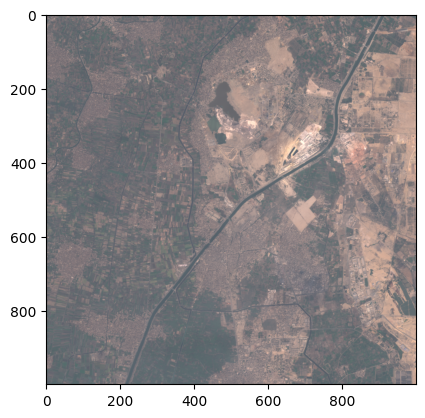

In [ ]:
# Read the patch files
band2 = rasterio.open(f"{Path.home()}/patch_band_2.jp2", driver="JP2OpenJPEG")  # blue
band3 = rasterio.open(f"{Path.home()}/patch_band_3.jp2", driver="JP2OpenJPEG")  # green
band4 = rasterio.open(f"{Path.home()}/patch_band_4.jp2", driver="JP2OpenJPEG")  # red

red = band4.read(1)
green = band3.read(1)
blue = band2.read(1)

# Normalize the pixel values and apply gain
gain = 2
red_n = np.clip(red * gain / 10000, 0, 1)
green_n = np.clip(green * gain / 10000, 0, 1)
blue_n = np.clip(blue * gain / 10000, 0, 1)

# Create composite image
rgb_composite_n = np.dstack((red_n, green_n, blue_n))

# Display image
plt.imshow(rgb_composite_n)

# Save image to file
matplotlib.image.imsave(f"{Path.home()}/Sentinel2_true_color.jpeg", rgb_composite_n)
print("Saved as:", outfile)

In [ ]:
# # Print minimum and maximum values of normalized bands
print("Red band - min:", red_n.min(), "max:", red_n.max())
print("Green band - min:", green_n.min(), "max:", green_n.max())
print("Blue band - min:", blue_n.min(), "max:", blue_n.max())

print("Composite image array:", rgb_composite_n)



print("Red band count:", band4.count)
print("Green band count:", band3.count)
print("Blue band count:", band2.count)


Red band - min: 0.3096 max: 1.0
Green band - min: 0.3504 max: 1.0
Blue band - min: 0.3958 max: 1.0
Composite image array: [[[0.4942 0.456  0.465 ]
  [0.4168 0.4358 0.4402]
  [0.4212 0.438  0.4418]
  ...
  [0.3682 0.3938 0.4212]
  [0.3718 0.4036 0.4272]
  [0.369  0.4118 0.427 ]]

 [[0.4452 0.4476 0.4524]
  [0.3942 0.4382 0.4416]
  [0.4172 0.4348 0.4416]
  ...
  [0.3662 0.3968 0.422 ]
  [0.3636 0.4052 0.4278]
  [0.3596 0.412  0.428 ]]

 [[0.4148 0.435  0.4414]
  [0.3854 0.4284 0.4408]
  [0.443  0.441  0.4492]
  ...
  [0.3688 0.399  0.4232]
  [0.3608 0.4086 0.4292]
  [0.3612 0.4136 0.43  ]]

 ...

 [[0.3588 0.392  0.424 ]
  [0.3562 0.3928 0.4272]
  [0.3568 0.393  0.4254]
  ...
  [0.734  0.6384 0.5758]
  [0.749  0.6384 0.579 ]
  [0.798  0.666  0.5946]]

 [[0.3592 0.3896 0.427 ]
  [0.3578 0.391  0.4264]
  [0.355  0.3932 0.4262]
  ...
  [0.76   0.6432 0.5776]
  [0.747  0.6346 0.5756]
  [0.8214 0.6664 0.5976]]

 [[0.3538 0.3966 0.4272]
  [0.3574 0.3972 0.428 ]
  [0.3596 0.3976 0.4304]
  ...
 

In [ ]:
# Ensure correct assignment of bands to RGB channels
print("Red band:", red_n.shape)  # Check shape to verify red channel
print("Green band:", green_n.shape)  # Check shape to verify green channel
print("Blue band:", blue_n.shape)  # Check shape to verify blue channel


Red band: (1000, 1000)
Green band: (1000, 1000)
Blue band: (1000, 1000)


## Exploring Satellite Imagery with Rasterio

### Create RGB Image
The true colour of satellite images is often displayed in a combination of red, green and blue band. Let us first read the data with Rasterio and create an RGB image from Bands 4, 3, and 2

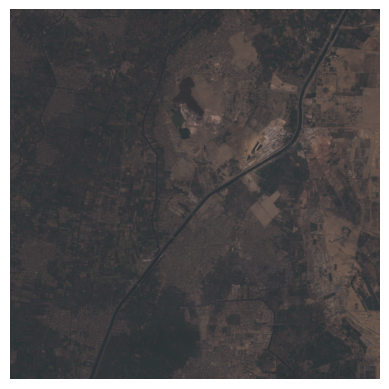

In [ ]:
import rasterio
import matplotlib.pyplot as plt


red_band_path = f"{Path.home()}/patch_band_4.jp2"
green_band_path = f"{Path.home()}/patch_band_3.jp2"
blue_band_path = f"{Path.home()}/patch_band_2.jp2"

# Open the raster bands
red_band = rasterio.open(red_band_path, driver="JP2OpenJPEG")
green_band = rasterio.open(green_band_path, driver="JP2OpenJPEG")
blue_band = rasterio.open(blue_band_path, driver="JP2OpenJPEG")

# Read band data
red = red_band.read(1)
green = green_band.read(1)
blue = blue_band.read(1)

# Normalize pixel values to the range [0, 1]
red_n = red / 10000.0
green_n = green / 10000.0
blue_n = blue / 10000.0

# Stack bands to create an RGB image
rgb_image = np.dstack((red_n, green_n, blue_n))

# Display the RGB image
plt.imshow(rgb_image)
plt.axis('off')  # Turn off axis labels
plt.show()


### Mask Satellite images

One important preprocessing task to clip or mask an area of study. Since this RGB image is large and huge you save both computing power and time to clip and use only the area of interest. We will clip the Natural reserve area from the RGB image

Raster CRS: EPSG:32636
Raster Bounds: BoundingBox(left=336870.0, bottom=3344190.0, right=346870.0, top=3354190.0)


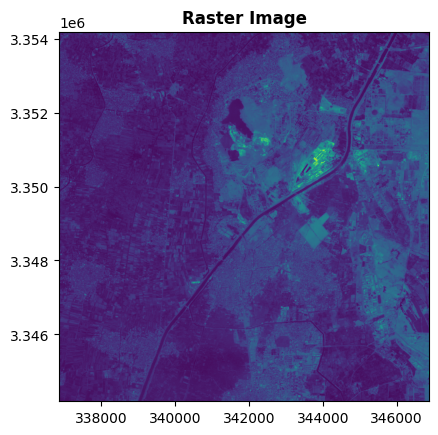

In [ ]:
import rasterio
from rasterio.plot import show

# Replace with your raster file path
raster_file_path = f"{Path.home()}/patch_band_2.jp2"

with rasterio.open(raster_file_path) as src:
    raster_crs = src.crs
    raster_bounds = src.bounds
    print("Raster CRS:", raster_crs)
    print("Raster Bounds:", raster_bounds)

    # Optionally, visualize the raster
    show(src, title="Raster Image")


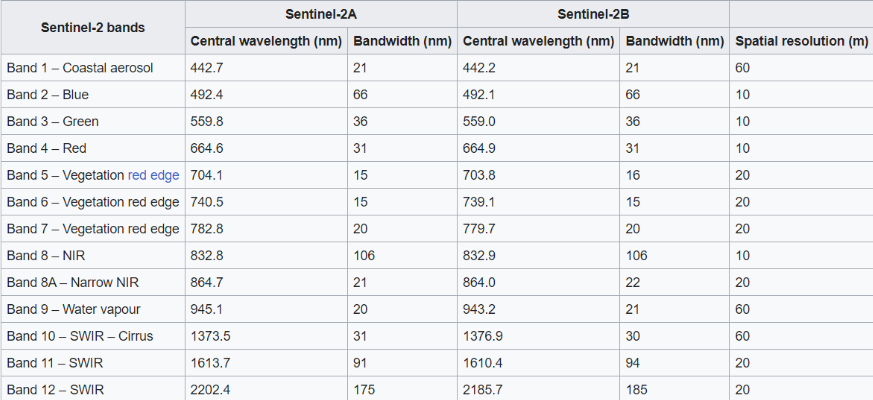

## Preprocessing for Extract Feature  from bands

##Establish an authenticated connection to Copernicus Data Space Ecosystem openEO back-end.



In [ ]:
 connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
 connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

##Basic NDVI Timeseries
Calculating Normalized Difference Vegetation Index (NDVI) is an important indicator to assess the presence/absence of green vegetation from the satellite images. To calculate the NDVI, you need Red band and Near-Infrared Band (NIR). Different satellite images assign different numbers for this band. Sentinel Images have red in 4th band and NIR in the 8th band. The formula for NDVI calculation is:
nir - red /(nir + red).

To carry out this in Rasterio we need first to read the 4th and 8th bands as arrays. We also need to make sure that the arrays are floats.

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)
#{"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.816406,31.217023],[31.58844,30.953655],[32.148743,30.888877],[32.196808,31.184142],[31.816406,31.217023]]]}},
     #   {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.393295,30.905539],[31.126877,30.633633],[31.483932,30.630089],[31.68512,30.949703],[31.393295,30.905539]]]}}
# {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.445068,30.72777],[30.943817,30.215413],[31.954147,30.802723],[31.754608,30.934],[31.445068,30.72777]]]}}
#{"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}
 #{"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}}
#{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}

##Load the “B04” (red) and “B08” (NIR) brands from the SENTINEL2_L2A collection for the desired time window for season of wheat for year (2020-2021):

##Calculate the NDVI (Feature 1)(YEAR (2020-2021)) for season of wheat:

Landsat Normalized Difference Vegetation Index (NDVI) is used to quantify vegetation greenness and is useful in understanding vegetation density and assessing changes in plant health

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-11-01","2021-05-10"],
    bands=["B04", "B08"],
)

In [ ]:
red = s2cube.band("B04")
nir = s2cube.band("B08")
ndvi = (nir - red) / (nir + red)

In [ ]:
timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="NDVI timeseries")

0:00:00 Job 'j-24041674acff435f965bf7944ca9c1f4': send 'start'
0:00:24 Job 'j-24041674acff435f965bf7944ca9c1f4': created (progress N/A)
0:00:29 Job 'j-24041674acff435f965bf7944ca9c1f4': created (progress N/A)
0:00:36 Job 'j-24041674acff435f965bf7944ca9c1f4': created (progress N/A)
0:00:44 Job 'j-24041674acff435f965bf7944ca9c1f4': created (progress N/A)
0:00:54 Job 'j-24041674acff435f965bf7944ca9c1f4': created (progress N/A)
0:01:07 Job 'j-24041674acff435f965bf7944ca9c1f4': running (progress N/A)
0:01:23 Job 'j-24041674acff435f965bf7944ca9c1f4': running (progress N/A)
0:01:42 Job 'j-24041674acff435f965bf7944ca9c1f4': running (progress N/A)
0:02:07 Job 'j-24041674acff435f965bf7944ca9c1f4': running (progress N/A)
0:02:37 Job 'j-24041674acff435f965bf7944ca9c1f4': running (progress N/A)
0:03:15 Job 'j-24041674acff435f965bf7944ca9c1f4': running (progress N/A)
0:04:03 Job 'j-24041674acff435f965bf7944ca9c1f4': running (progress N/A)
0:05:02 Job 'j-24041674acff435f965bf7944ca9c1f4': running (pr

In [ ]:
import json
import csv

# Load GeoJSON data from the 'fields' dictionary
fields = json.loads("""
{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}

    ]
}
""")
#  {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.816406,31.217023],[31.58844,30.953655],[32.148743,30.888877],[32.196808,31.184142],[31.816406,31.217023]]]}},
#  {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.393295,30.905539],[31.126877,30.633633],[31.483932,30.630089],[31.68512,30.949703],[31.393295,30.905539]]]}},
#  {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.445068,30.72777],[30.943817,30.215413],[31.954147,30.802723],[31.754608,30.934],[31.445068,30.72777]]]}}

# Extract coordinates from the 'fields' dictionary
coordinates_list = []
for feature in fields['features']:
    coordinates = feature['geometry']['coordinates'][0]  # Extracting the first set of coordinates
    coordinates_list.append([(point[1], point[0]) for point in coordinates])  # Extracting (latitude, longitude) pairs

# Write coordinates to CSV file
with open('coordinates.csv', 'w', newline='') as csvfile:
    fieldnames = ['Latitude', 'Longitude']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for coordinates in coordinates_list:
        for lat, lon in coordinates:
            writer.writerow({'Latitude': lat, 'Longitude': lon})

print("Coordinates have been saved to coordinates.csv")


Coordinates have been saved to coordinates.csv


In [ ]:
df= pd.read_csv("coordinates.csv")
df

,Latitude,Longitude
0,31.017742,31.483658
1,30.809080,31.335617
2,30.636047,31.822449
3,30.884188,32.009216
4,30.975001,31.808167
5,31.017742,31.483658
6,31.222998,31.697205
7,30.703006,31.163132
8,30.512965,31.438889
9,31.053455,31.978180


##Download the timeseries CSV:

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-basic.csv") # (113,3)

PosixPath('ndvi-results/timeseries-basic.csv')

In [ ]:
pd.read_csv("ndvi-results/timeseries-basic.csv", index_col=0).head(13)


,feature_index,avg(band_0)
date,,
2020-11-09T00:00:00.000Z,1,0.453314
2020-11-04T00:00:00.000Z,0,0.256912
2020-11-04T00:00:00.000Z,1,0.239186
2020-11-09T00:00:00.000Z,0,0.421886
2020-11-19T00:00:00.000Z,0,0.457664
2020-11-19T00:00:00.000Z,1,0.495458
2020-11-24T00:00:00.000Z,1,0.391590
2020-11-14T00:00:00.000Z,1,0.330990
2020-11-17T00:00:00.000Z,1,0.261065


In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
ndvi_data = pd.read_csv("ndvi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
ndvi_data["Latitude"] = coordinates_data["Latitude"]
ndvi_data["Longitude"] = coordinates_data["Longitude"]




In [ ]:
ndvi_data.shape

(113, 5)

In [ ]:

ndvi_data.head(12)

,date,feature_index,avg(band_0),Latitude,Longitude
0,2020-11-09T00:00:00.000Z,1,0.453314,31.017742,31.483658
1,2020-11-04T00:00:00.000Z,0,0.256912,30.809080,31.335617
2,2020-11-04T00:00:00.000Z,1,0.239186,30.636047,31.822449
3,2020-11-09T00:00:00.000Z,0,0.421886,30.884188,32.009216
4,2020-11-19T00:00:00.000Z,0,0.457664,30.975001,31.808167
5,2020-11-19T00:00:00.000Z,1,0.495458,31.017742,31.483658
6,2020-11-24T00:00:00.000Z,1,0.391590,31.222998,31.697205
7,2020-11-14T00:00:00.000Z,1,0.330990,30.703006,31.163132
8,2020-11-17T00:00:00.000Z,1,0.261065,30.512965,31.438889
9,2020-11-14T00:00:00.000Z,0,0.297702,31.053455,31.978180


In [ ]:
ndvi_data_cleaned = ndvi_data.dropna()

In [ ]:
# ndvi_data.shape
ndvi_data_cleaned.shape

(11, 5)

In [ ]:
ndvi_data_cleaned.to_csv("ndvi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
ndvi_data_cleaned.head(18)

,date,feature_index,avg(band_0),Latitude,Longitude
0,2020-11-09T00:00:00.000Z,1,0.453314,31.017742,31.483658
1,2020-11-04T00:00:00.000Z,0,0.256912,30.809080,31.335617
2,2020-11-04T00:00:00.000Z,1,0.239186,30.636047,31.822449
3,2020-11-09T00:00:00.000Z,0,0.421886,30.884188,32.009216
4,2020-11-19T00:00:00.000Z,0,0.457664,30.975001,31.808167
5,2020-11-19T00:00:00.000Z,1,0.495458,31.017742,31.483658
6,2020-11-24T00:00:00.000Z,1,0.391590,31.222998,31.697205
7,2020-11-14T00:00:00.000Z,1,0.330990,30.703006,31.163132
8,2020-11-17T00:00:00.000Z,1,0.261065,30.512965,31.438889
9,2020-11-14T00:00:00.000Z,0,0.297702,31.053455,31.978180


In [ ]:
ndvi_csv = pd.read_csv("ndvi-results/timeseries-basiccleaned.csv")
ndvi_csv.head(15)

,date,feature_index,avg(band_0),Latitude,Longitude
0,2020-11-09T00:00:00.000Z,1,0.453314,31.017742,31.483658
1,2020-11-04T00:00:00.000Z,0,0.256912,30.809080,31.335617
2,2020-11-04T00:00:00.000Z,1,0.239186,30.636047,31.822449
3,2020-11-09T00:00:00.000Z,0,0.421886,30.884188,32.009216
4,2020-11-19T00:00:00.000Z,0,0.457664,30.975001,31.808167
5,2020-11-19T00:00:00.000Z,1,0.495458,31.017742,31.483658
6,2020-11-24T00:00:00.000Z,1,0.391590,31.222998,31.697205
7,2020-11-14T00:00:00.000Z,1,0.330990,30.703006,31.163132
8,2020-11-17T00:00:00.000Z,1,0.261065,30.512965,31.438889
9,2020-11-14T00:00:00.000Z,0,0.297702,31.053455,31.978180


##Create a quick plot helper to visualize the NDVI data:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_timeseries(filename, figsize=(15, 8)):
    df = pd.read_csv(filename)
    df["date"] = pd.to_datetime(df["date"])

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    for feature_index, group in df.groupby("feature_index"):
        ax.plot(group["date"], group["avg(band_0)"], marker="o", label=f"Parcel ID: {feature_index}")

    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDVI")
    ax.set_ylim(0, 1)
    ax.legend(title="Parcel ID", loc="lower left", ncol=2)

    # Add Latitude and Longitude markers
    for i, row in df.iterrows():
        ax.text(row["date"], row["avg(band_0)"], f"Lat: {row['Latitude']}, Lon: {row['Longitude']}", fontsize=8)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



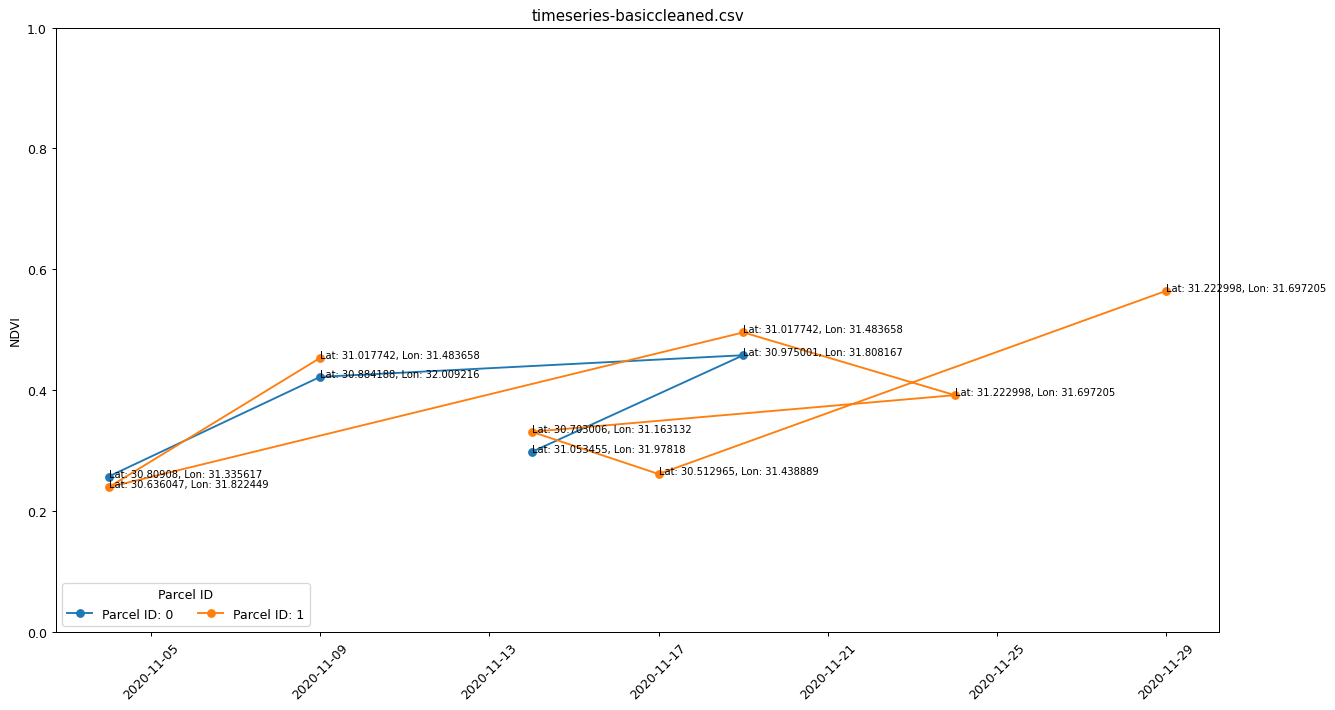

In [ ]:
plot_timeseries("ndvi-results/timeseries-basiccleaned.csv")

##Cloud Masking in NDVI

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-11-01","2021-05-10"],
    bands=["B04", "B08", "SCL"],
)
red = s2cube.band("B04")
nir = s2cube.band("B08")
ndvi = (nir - red) / (nir + red)

In [ ]:
scl = s2cube.band("SCL")
mask = ~((scl == 4) | (scl == 5))

In [ ]:
# 2D gaussian kernel
g = scipy.signal.windows.gaussian(11, std=1.6)
kernel = np.outer(g, g)
kernel = kernel / kernel.sum()

# Morphological dilation of mask: convolution + threshold
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

In [ ]:
ndvi_masked = ndvi.mask(mask)
timeseries_masked = ndvi_masked.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries_masked.execute_batch(out_format="CSV", title="Maked NDVI timeseries")


0:00:00 Job 'j-240323717e464a528ddcb406c8e965f5': send 'start'
0:00:15 Job 'j-240323717e464a528ddcb406c8e965f5': created (progress N/A)
0:00:20 Job 'j-240323717e464a528ddcb406c8e965f5': created (progress N/A)
0:00:27 Job 'j-240323717e464a528ddcb406c8e965f5': created (progress N/A)
0:00:35 Job 'j-240323717e464a528ddcb406c8e965f5': created (progress N/A)
0:00:45 Job 'j-240323717e464a528ddcb406c8e965f5': created (progress N/A)
0:00:58 Job 'j-240323717e464a528ddcb406c8e965f5': running (progress N/A)
0:01:14 Job 'j-240323717e464a528ddcb406c8e965f5': running (progress N/A)
0:01:33 Job 'j-240323717e464a528ddcb406c8e965f5': running (progress N/A)
0:01:57 Job 'j-240323717e464a528ddcb406c8e965f5': running (progress N/A)
0:02:27 Job 'j-240323717e464a528ddcb406c8e965f5': running (progress N/A)
0:03:05 Job 'j-240323717e464a528ddcb406c8e965f5': running (progress N/A)
0:03:52 Job 'j-240323717e464a528ddcb406c8e965f5': running (progress N/A)
0:04:51 Job 'j-240323717e464a528ddcb406c8e965f5': running (pr

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-masked.csv")

PosixPath('ndvi-results/timeseries-masked.csv')

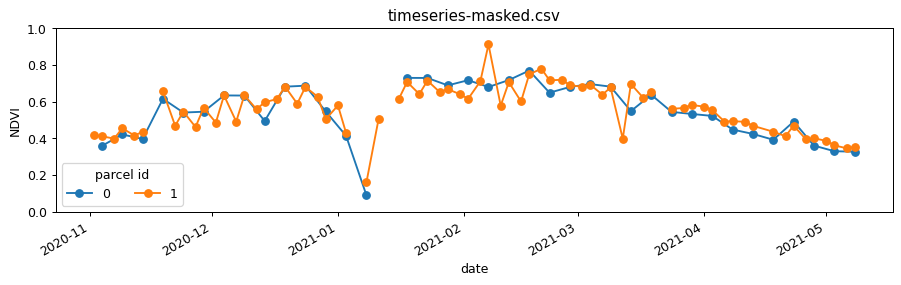

In [ ]:
plot_timeseries("ndvi-results/timeseries-masked.csv")

##Timeseries Smoothing

In [ ]:
udf = openeo.UDF(
    """
from scipy.signal import savgol_filter
from openeo.udf import XarrayDataCube

def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    array = cube.get_array()
    filled = array.interpolate_na(dim='t')
    smoothed_array = savgol_filter(filled.values, 5, 2, axis=0)
    return XarrayDataCube(xarray.DataArray(smoothed_array, dims=array.dims, coords=array.coords))
"""
)


In [ ]:
ndvi_smoothed = ndvi_masked.apply_dimension(code=udf, dimension="t")

In [ ]:
timeseries_smoothed = ndvi_smoothed.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries_smoothed.execute_batch(
    out_format="CSV", title="Smoothed NDVI timeseries"
)

0:00:00 Job 'j-2402275705b046e498d07eb1f6749443': send 'start'
0:00:22 Job 'j-2402275705b046e498d07eb1f6749443': created (progress N/A)
0:00:28 Job 'j-2402275705b046e498d07eb1f6749443': created (progress N/A)
0:00:35 Job 'j-2402275705b046e498d07eb1f6749443': created (progress N/A)
0:00:44 Job 'j-2402275705b046e498d07eb1f6749443': created (progress N/A)
0:00:54 Job 'j-2402275705b046e498d07eb1f6749443': created (progress N/A)
0:01:07 Job 'j-2402275705b046e498d07eb1f6749443': created (progress N/A)
0:01:28 Job 'j-2402275705b046e498d07eb1f6749443': running (progress N/A)
0:01:47 Job 'j-2402275705b046e498d07eb1f6749443': running (progress N/A)
0:02:11 Job 'j-2402275705b046e498d07eb1f6749443': running (progress N/A)
0:02:42 Job 'j-2402275705b046e498d07eb1f6749443': running (progress N/A)
0:03:20 Job 'j-2402275705b046e498d07eb1f6749443': running (progress N/A)
0:04:07 Job 'j-2402275705b046e498d07eb1f6749443': running (progress N/A)
0:05:07 Job 'j-2402275705b046e498d07eb1f6749443': running (pr

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-smoothed.csv")

PosixPath('ndvi-results/timeseries-smoothed.csv')

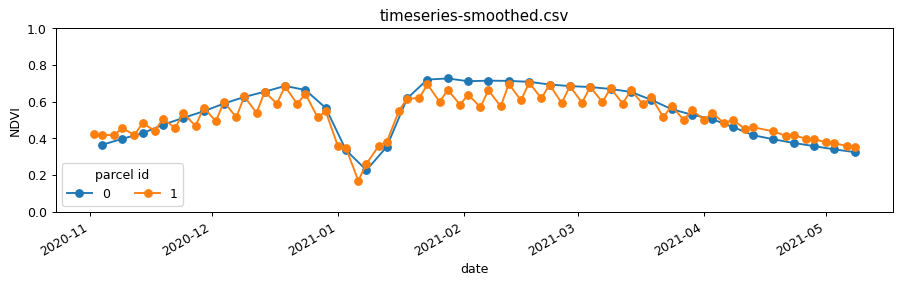

In [ ]:
plot_timeseries("ndvi-results/timeseries-smoothed.csv")

In [ ]:
df=pd.read_csv("ndvi-results/timeseries-smoothed.csv")

In [ ]:
df.head(10)

,date,feature_index,avg(band_0)
0,2020-11-04T00:00:00.000Z,1,0.418290
1,2020-11-09T00:00:00.000Z,1,0.456573
2,2020-11-09T00:00:00.000Z,0,0.398209
3,2020-11-24T00:00:00.000Z,1,0.539059
4,2020-11-24T00:00:00.000Z,0,0.512239
5,2020-11-19T00:00:00.000Z,1,0.506801
6,2020-11-29T00:00:00.000Z,1,0.567619
7,2020-11-29T00:00:00.000Z,0,0.548380
8,2020-12-04T00:00:00.000Z,1,0.599927
9,2020-12-07T00:00:00.000Z,1,0.515112


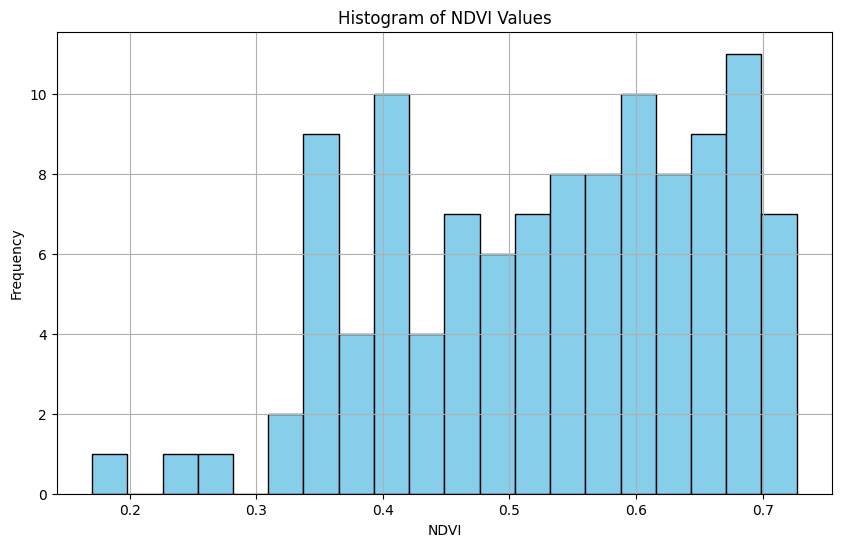

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the data
data = pd.read_csv("ndvi-results/timeseries-smoothed.csv")

# Convert the date column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Plotting Histogram
plt.figure(figsize=(10, 6))
plt.hist(data['avg(band_0)'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of NDVI Values')
plt.xlabel('NDVI')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# df.isnull().sum()
df.isna().sum()

date             0
feature_index    0
avg(band_0)      0
dtype: int64

##Rasterization after time smoothing

In [ ]:
!pip install gdal
!pip install pandas numpy rasterio


In [ ]:
import os
os.environ['GDAL_DATA'] = '/usr/local/lib/python3.7/dist-packages/osgeo/data/gdal'
os.environ['PROJ_LIB'] = '/usr/local/lib/python3.7/dist-packages/osgeo/data/proj'
os.environ['PATH'] += ':/usr/local/lib/python3.7/dist-packages/osgeo'


In [ ]:
import json

# Load the GeoJSON data
fields = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "type":"Polygon",
                "coordinates":[
                    [[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]
                ]
            }
        }
    ]
}

# Extract the coordinates from the GeoJSON
coordinates = fields['features'][0]['geometry']['coordinates'][0]  # Extracting the first set of coordinates
lons, lats = zip(*coordinates)  # Separate longitudes (x) and latitudes (y)

# Determine the spatial extent
xmin = min(lons)
ymin = min(lats)
xmax = max(lons)
ymax = max(lats)

# Create GeoJSON for the bounding box
bbox_geojson = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [[xmin, ymin], [xmin, ymax], [xmax, ymax], [xmax, ymin], [xmin, ymin]]
        ]
    }
}

# Convert the bounding box GeoJSON to a string
bbox_geojson_str = json.dumps(bbox_geojson, indent=2)

print("Bounding box GeoJSON:")
print(bbox_geojson_str)


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv('combined_modified.csv') # the new file that was cleaned

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
ndvi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output1.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    ndvi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, ndvi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            ndvi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(ndvi_grid, 1)


In [ ]:
import rasterio

# Open the GeoTIFF file
with rasterio.open("raster_output1.tif") as src:
    # Get the dimensions of the raster
    width = src.width
    height = src.height

print(f"The length (height) of the raster is: {height}")
print(f"The width of the raster is: {width}")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load combined CSV file
combined_df = pd.read_csv('combined_modified.csv')

# Extract latitude and longitude values
latitude = combined_df['Latitude']
longitude = combined_df['Longitude']

# Plot input pixels
plt.figure(figsize=(5, 5))
plt.scatter(longitude, latitude, c='red', marker='o', label='Input Pixels')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Input Pixels')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import rasterio

# Open the GeoTIFF file
with rasterio.open("raster_output1.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Print the pixel values
    print("Pixel values of the raster:")
    for row in raster_data:
        print(row)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output1.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='NDVI')
    plt.title('NDVI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


## Calculating NDWI (Feature 2)(YEAR (2020-2021)) with bands 3 and 8 " Green & NIR  "

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-11-01","2021-05-10"],
    bands=["B03", "B08"],  # Adjust bands for NDWI calculation
)

In [ ]:
# Calculate NDWI
green = s2cube.band("B03")  # Green band
nir = s2cube.band("B08")    # NIR band
ndwi = (green - nir) / (green + nir)

In [ ]:
timeseries = ndwi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
# Execute the job and download the results
job = timeseries.execute_batch(out_format="CSV", title="NDWI_timeseries")
job.get_results().download_file("ndwi_results/timeseries_basic.csv")

In [ ]:
pd.read_csv("ndwi_results/timeseries_basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
ndwi_data = pd.read_csv("ndwi_results/timeseries_basic.csv")

# Add latitude and longitude columns to ndvi_data
ndwi_data["Latitude"] = coordinates_data["Latitude"]
ndwi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
ndwi_data.shape

In [ ]:
ndwi_data.head(12)

In [ ]:
ndwi_data_cleaned = ndwi_data.dropna()

In [ ]:
# ndvi_data.shape
ndwi_data_cleaned.shape

In [ ]:
ndwi_data_cleaned.to_csv("ndwi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
ndwi_data_cleaned.head(18)

In [ ]:
ndwi_csv = pd.read_csv("ndwi-results/timeseries-basiccleaned.csv")
ndwi_csv.head(15)

In [ ]:
# Plot the NDWI time series
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDWI")
    ax.set_ylim(-1, 1)  # NDWI values typically range from -1 to 1
    ax.legend(title="parcel id", loc="lower left", ncol=2)

plot_timeseries("ndwi-results/timeseries-basiccleaned.csv")
plt.show()

##Rasterization for NDWI

In [ ]:
df= pd.read_csv("coordinates.csv")
df

In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
ndWi_df = pd.read_csv("ndwi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of NDWI DataFrame:", ndWi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of NDWI DataFrame:")
print(ndWi_df.head())

In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("ndwi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
ndwi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output2.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    ndwi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, ndvi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            ndwi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(ndwi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output2.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='NDWI')
    plt.title('NDwI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating NDSI (Feature 3)(YEAR (2020-2021))  with bands 3 and 11 " Green & SWIR "

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-11-01","2021-05-10"],
    bands=["B03", "B11"],
)

In [ ]:
green = s2cube.band("B03")
swir = s2cube.band("B11")
ndsi = (green - swir) / (green + swir)

In [ ]:
timeseries = ndsi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="NDSI timeseries")

In [ ]:
job.get_results().download_file("ndsi-results/timeseries-basic.csv")
pd.read_csv("ndsi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
ndsi_data = pd.read_csv("ndsi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
ndsi_data["Latitude"] = coordinates_data["Latitude"]
ndsi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
ndsi_data.shape

In [ ]:
ndsi_data.head(12)

In [ ]:
ndsi_data_cleaned = ndsi_data.dropna()

In [ ]:
# ndvi_data.shape
ndsi_data_cleaned.shape

In [ ]:
ndsi_data_cleaned.to_csv("ndsi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
ndsi_data_cleaned.head(18)

In [ ]:
ndsi_csv = pd.read_csv("ndsi-results/timeseries-basiccleaned.csv")
ndsi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDSI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("ndsi-results/timeseries-basiccleaned.csv")

##Rasterization for NDSI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
ndsi_df = pd.read_csv("ndsi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of NDsI DataFrame:", ndsi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of NDsI DataFrame:")
print(ndsi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("ndsi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]


latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
ndsi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output3.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:

    ndsi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, ndsi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            ndsi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")


    dst.write(ndsi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output3.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='NDSI')
    plt.title('NDsI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating GNDVI (Feature 4)(YEAR (2020-2021)) with bands 3 and 8 " Green &  NIR "

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-11-01","2021-05-10"],
    bands=["B03", "B08"],
)

In [ ]:
green = s2cube.band("B03")
nir = s2cube.band("B08")
ndvi = (nir - green) / (nir + green)

In [ ]:
timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="GNDVI timeseries")

In [ ]:
job.get_results().download_file("gndvi-results/timeseries-basic.csv")
pd.read_csv("gndvi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
gndvi_data = pd.read_csv("gndvi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
gndvi_data["Latitude"] = coordinates_data["Latitude"]
gndvi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
gndvi_data.shape

In [ ]:
gndvi_data.head(12)

In [ ]:
gndvi_data_cleaned = gndvi_data.dropna()

In [ ]:
# ndvi_data.shape
gndvi_data_cleaned.shape

In [ ]:
gndvi_data_cleaned.to_csv("gndvi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
gndvi_data_cleaned.head(18)

In [ ]:
gndvi_csv = pd.read_csv("gndvi-results/timeseries-basiccleaned.csv")
gndvi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("gndvi-results/timeseries-basiccleaned.csv")

## Rasterization for GNDVI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
# Load the CSV file containing the NDVI time series
gndvi_df = pd.read_csv("gndvi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of GNDvI DataFrame:", ndWi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of GNDvI DataFrame:")
print(gndvi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("gndvi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
gndvi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output4.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:

    gndvi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, gndvi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            gndvi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")


    dst.write(gndvi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output4.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='GNDVI')
    plt.title('GNDVI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating EVI (Feature 5)(YEAR (2020-2021)) with bands 3 , 8 and blue  

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-11-01","2021-05-10"],
    bands=["B04", "B08","B03"],
)

In [ ]:
red = s2cube.band("B04")
nir = s2cube.band("B08")
blue = s2cube.band("B03")
c1=6
c2=7.5
l=1
evi = 2.5 * ((nir - red) / (nir + c1 * red - c2 * blue + l))

In [ ]:
timeseries = evi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="evi timeseries")

In [ ]:
job.get_results().download_file("evi-results/timeseries-basic.csv")
pd.read_csv("evi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
evi_data = pd.read_csv("evi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
evi_data["Latitude"] = coordinates_data["Latitude"]
evi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
evi_data.shape

In [ ]:
evi_data.head(12)

In [ ]:
evi_data_cleaned = evi_data.dropna()

In [ ]:
# ndvi_data.shape
evi_data_cleaned.shape

In [ ]:
evi_data_cleaned.to_csv("evi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
evi_data_cleaned.head(18)

In [ ]:
evi_csv = pd.read_csv("evi-results/timeseries-basiccleaned.csv")
evi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("EVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("evi-results/timeseries-basiccleaned.csv")

## Rasterization for evi

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
evi_df = pd.read_csv("evi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of evi DataFrame:", evi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of evi DataFrame:")
print(evi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("evi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
evi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output5.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    evi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, evi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            evi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(evi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output5.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='EVI')
    plt.title('EVi Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating Moisture index (Feature 6)(YEAR (2020-2021)) with bands 8A , 11 "narrow nir & swir"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-11-01","2021-05-10"],
    bands=["B8A", "B11"],
)

In [ ]:
narrow = s2cube.band("B8A")
swir = s2cube.band("B11")
moisture = (narrow - swir) / (narrow + swir)

In [ ]:
timeseries = moisture.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="MOISTURE timeseries")

In [ ]:
job.get_results().download_file("moisture-results/timeseries-basic.csv")

In [ ]:
pd.read_csv("moisture-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
moisture_data = pd.read_csv("moisture-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
moisture_data["Latitude"] = coordinates_data["Latitude"]
moisture_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
moisture_data.shape

In [ ]:
moisture_data.head(12)


In [ ]:
moisture_data_cleaned = moisture_data.dropna()

In [ ]:
# ndvi_data.shape
moisture_data_cleaned.shape

In [ ]:
moisture_data_cleaned.to_csv("moisture-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
moisture_data_cleaned.head(18)

In [ ]:
moisture_csv = pd.read_csv("moisture-results/timeseries-basiccleaned.csv")
moisture_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("moisture")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("moisture-results/timeseries-basiccleaned.csv")

## Rasterization for moisture

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd


moisture_df = pd.read_csv("moisture-results/timeseries-basiccleaned.csv", index_col=0)


print("Shape of mositure DataFrame:", ndWi_df.shape)


print("First few rows of moisture DataFrame:")
print(moisture_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("moisture-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
moisture = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output6.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:

    moisture_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, moisture):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            moisture_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")


    dst.write(moisture_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output6.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='moisture')
    plt.title('moisture Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


## Layer stack of seasion wheat For year 2020 :

In [ ]:
from osgeo import gdal

# List of input raster files
input_files = [
    "raster_output1.tif",
    "raster_output2.tif",
    "raster_output3.tif",
    "raster_output4.tif",
    "raster_output5.tif",
    "raster_output6.tif"
]

# Output file name for the layer stack
output_file = "layer_stack2020W.tif"

# Open the first raster file to get the metadata
first_dataset = gdal.Open(input_files[0])
if first_dataset is None:
    print("Failed to open the first input file.")
    exit(1)

# Get metadata from the first raster file
driver = first_dataset.GetDriver()
rows, cols = first_dataset.RasterYSize, first_dataset.RasterXSize
projection = first_dataset.GetProjection()
geotransform = first_dataset.GetGeoTransform()
dtype = first_dataset.GetRasterBand(1).DataType

# Create output dataset
output_dataset = driver.Create(output_file, cols, rows, len(input_files), dtype)
if output_dataset is None:
    print("Failed to create output file.")
    exit(1)

# Set projection and geotransform
output_dataset.SetProjection(projection)
output_dataset.SetGeoTransform(geotransform)

# Iterate over input files and write bands to the output dataset
for i, input_file in enumerate(input_files):
    input_dataset = gdal.Open(input_file)
    if input_dataset is None:
        print(f"Failed to open input file: {input_file}")
        continue

    band = input_dataset.GetRasterBand(1)
    output_band = output_dataset.GetRasterBand(i + 1)
    output_band.WriteArray(band.ReadAsArray())

    input_dataset = None

output_dataset = None

print("Layer stack creation complete.")


##Load the “B04” (red) and “B08” (NIR)(Feature 1) bands from the SENTINEL2_L2A collection for the desired time window for season of wheat for year (2021):

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2021-11-01","2022-05-10"],
    bands=["B04", "B08"],
)

In [ ]:
red = s2cube.band("B04")
nir = s2cube.band("B08")
ndvi = (nir - red) / (nir + red)

In [ ]:
timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="NDVI timeseries")

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-basic.csv")
pd.read_csv("ndvi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
ndvi_data = pd.read_csv("ndvi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
ndvi_data["Latitude"] = coordinates_data["Latitude"]
ndvi_data["Longitude"] = coordinates_data["Longitude"]


In [ ]:
ndvi_data.shape

In [ ]:
ndvi_data.head(12)

In [ ]:
ndvi_data_cleaned = ndvi_data.dropna()

In [ ]:
# ndvi_data.shape
ndvi_data_cleaned.shape


In [ ]:
ndvi_data_cleaned.to_csv("ndvi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
ndvi_data_cleaned.head(18)

In [ ]:
ndvi_csv = pd.read_csv("ndvi-results/timeseries-basiccleaned.csv")
ndvi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("ndvi-results/timeseries-basiccleaned.csv")

##Cloud Masking in NDVI

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2021-11-01","2022-05-10"],
    bands=["B04", "B08", "SCL"],
)
red = s2cube.band("B04")
nir = s2cube.band("B08")
ndvi = (nir - red) / (nir + red)

In [ ]:
scl = s2cube.band("SCL")
mask = ~((scl == 4) | (scl == 5))

In [ ]:
# 2D gaussian kernel
g = scipy.signal.windows.gaussian(11, std=1.6)
kernel = np.outer(g, g)
kernel = kernel / kernel.sum()

# Morphological dilation of mask: convolution + threshold
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

In [ ]:
ndvi_masked = ndvi.mask(mask)
timeseries_masked = ndvi_masked.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries_masked.execute_batch(out_format="CSV", title="Maked NDVI timeseries")

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-masked.csv")

In [ ]:
plot_timeseries("ndvi-results/timeseries-masked.csv")

##Timeseries Smoothing

In [ ]:
udf = openeo.UDF(
    """
from scipy.signal import savgol_filter
from openeo.udf import XarrayDataCube

def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    array = cube.get_array()
    filled = array.interpolate_na(dim='t')
    smoothed_array = savgol_filter(filled.values, 5, 2, axis=0)
    return DataCube(xarray.DataArray(smoothed_array, dims=array. dims,coords=array.coords))
"""
)

In [ ]:
ndvi_smoothed = ndvi_masked.apply_dimension(code=udf, dimension="t")

In [ ]:
timeseries_smoothed = ndvi_smoothed.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries_smoothed.execute_batch(
    out_format="CSV", title="Smoothed NDVI timeseries"
)

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-smoothed.csv")

In [ ]:
plot_timeseries("ndvi-results/timeseries-smoothed.csv")

## Rasterization for ndvi 2021

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
ndvi_df = pd.read_csv("ndvi-results/timeseries-smoothed.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of NDvI DataFrame:", ndvi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of NDvI DataFrame:")
print(ndvi_df.head())


In [ ]:
import pandas as pd

# Load CSV files into DataFrames
coordinates_df = pd.read_csv('coordinates.csv')
timeseries_df = pd.read_csv("ndvi-results/timeseries-smoothed.csv")

# Concatenate DataFrames along the column axis
combined_df = pd.concat([coordinates_df, timeseries_df], axis=1)

# Print the combined DataFrame
print(combined_df.head())

# Save the combined DataFrame to a new CSV file
combined_df.to_csv('combinedndvi.csv', index=False)


In [ ]:
df=pd.read_csv("combinedndvi.csv")
df.shape

In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('combinedndvi.csv')

# Drop rows from 12 to 113
df.drop(range(11, 110), inplace=True)

# Save the modified data to a new CSV file
df.to_csv('combined_modified.csv', index=False)

print("Rows 12 to 110 have been dropped and the modified data has been saved to combined_modified.csv")


In [ ]:
df=pd.read_csv('combinedndvi.csv')
df


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv('combinedndvi.csv')

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
ndvi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output7.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    ndvi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, ndvi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            ndvi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(ndvi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output7.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='NDVI')
    plt.title('NDVI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calcualting NDWI (Feature 2)(YEAR 2021) with bands 3 and 8 " Green & NIR "

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2021-11-01","2022-05-10"],
    bands=["B03", "B08"],
)

In [ ]:
green = s2cube.band("B03")
nir = s2cube.band("B08")
ndwi = (green - nir) / (green + nir)

In [ ]:
timeseries = ndwi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="NDWI timeseries")

In [ ]:
job.get_results().download_file("ndwi-results/timeseries-basic.csv")
pd.read_csv("ndwi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
ndwi_data = pd.read_csv("ndwi_results/timeseries_basic.csv")

# Add latitude and longitude columns to ndvi_data
ndwi_data["Latitude"] = coordinates_data["Latitude"]
ndwi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
ndwi_data.shape

In [ ]:
ndwi_data.head(12)

In [ ]:
ndwi_data_cleaned = ndwi_data.dropna()

In [ ]:
# ndvi_data.shape
ndwi_data_cleaned.shape

In [ ]:
ndwi_data_cleaned.to_csv("ndwi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
ndwi_data_cleaned.head(18)

In [ ]:
ndwi_csv = pd.read_csv("ndwi-results/timeseries-basiccleaned.csv")
ndwi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDWi")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("ndwi-results/timeseries-basiccleaned.csv")

## Rasterization for NDWI 2021

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
ndWi_df = pd.read_csv("ndwi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of NDWI DataFrame:", ndWi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of NDWI DataFrame:")
print(ndWi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("ndwi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
ndwi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output8.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:

    ndwi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, ndvi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            ndwi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")


    dst.write(ndwi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output8.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='NDWI')
    plt.title('NDWI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating NDSI (Feature 3)(YEAR 2021) with bands 3 and 11 " Green & SWIR "

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2021-11-01","2022-05-10"],
    bands=["B03", "B11"],
)

In [ ]:
green = s2cube.band("B03")
swir = s2cube.band("B11")
ndsi = (green - swir) / (green + swir)

In [ ]:
timeseries = ndsi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="NDSI timeseries")

In [ ]:
job.get_results().download_file("ndsi-results/timeseries-basic.csv")
pd.read_csv("ndsi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
ndsi_data = pd.read_csv("ndsi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
ndsi_data["Latitude"] = coordinates_data["Latitude"]
ndsi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
ndsi_data.shape

In [ ]:
ndsi_data.head(12)

In [ ]:
ndsi_data_cleaned = ndsi_data.dropna()

In [ ]:
# ndvi_data.shape
ndsi_data_cleaned.shape

In [ ]:
ndsi_data_cleaned.to_csv("ndsi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
ndsi_data_cleaned.head(18)

In [ ]:
ndsi_csv = pd.read_csv("ndsi-results/timeseries-basiccleaned.csv")
ndsi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDSI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("ndsi-results/timeseries-basiccleaned.csv")

## Rasterization for NDSI 2021

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

ndSi_df = pd.read_csv("ndsi-results/timeseries-basiccleaned.csv", index_col=0)


print("Shape of NDSI DataFrame:", ndSi_df.shape)


print("First few rows of NDSI DataFrame:")
print(ndSi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("ndsi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]


latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
ndsi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output9.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:

    ndsi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, ndsi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            ndsi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")


    dst.write(ndsi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output9.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='NDsI')
    plt.title('NDsI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating GNDVI (Feature 4)(YEAR 2021) with bands 3 and 8 " Green & NIR "

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2021-11-01","2022-05-10"],
    bands=["B03", "B08"],
)

In [ ]:
green = s2cube.band("B03")
nir = s2cube.band("B08")
ndvi = (nir - green) / (nir + green)

In [ ]:
timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="GNDVI timeseries")

In [ ]:
job.get_results().download_file("gndvi-results/timeseries-basic.csv")


In [ ]:
pd.read_csv("gndvi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
gndvi_data = pd.read_csv("gndvi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
gndvi_data["Latitude"] = coordinates_data["Latitude"]
gndvi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
gndvi_data.shape

In [ ]:
gndvi_data.head(12)

In [ ]:
gndvi_data_cleaned = gndvi_data.dropna()

In [ ]:
gndvi_data_cleaned.shape

In [ ]:
gndvi_data_cleaned.to_csv("gndvi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
gndvi_data_cleaned.head(18)

In [ ]:
gndvi_csv = pd.read_csv("gndvi-results/timeseries-basiccleaned.csv")
gndvi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("gndvi-results/timeseries-basiccleaned.csv")

## Rasterization For GNDVI 2021

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd


Gndvi_df = pd.read_csv("gndvi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of GNDvI DataFrame:", ndWi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of Gndvi DataFrame:")
print(Gndvi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("gndvi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]


latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
gndvi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output10.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:

    gndvi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, gndvi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            gndvi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")


    dst.write(gndvi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output10.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='GNDVI')
    plt.title('GNDVI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating EVI (Feature 5)(YEAR 2021) with bands 3 , 8 and blue

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2021-11-01","2022-05-10"],
    bands=["B04", "B08","B03"],
)

In [ ]:
red = s2cube.band("B04")
nir = s2cube.band("B08")
blue = s2cube.band("B03")
c1=6
c2=7.5
l=1
evi = 2.5 * ((nir - red) / (nir + c1 * red - c2 * blue + l))

In [ ]:
timeseries = evi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="evi timeseries")

In [ ]:
job.get_results().download_file("evi-results/timeseries-basic.csv")
pd.read_csv("evi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
evi_data = pd.read_csv("evi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
evi_data["Latitude"] = coordinates_data["Latitude"]
evi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
evi_data.shape

In [ ]:
evi_data.head(12)

In [ ]:
evi_data_cleaned = evi_data.dropna()

In [ ]:
evi_data_cleaned.shape

In [ ]:
evi_data_cleaned.to_csv("evi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
evi_data_cleaned.head(18)

In [ ]:
evi_csv = pd.read_csv("evi-results/timeseries-basiccleaned.csv")
evi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("EVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("evi-results/timeseries-basiccleaned.csv")

## Rasterization for EVi 2021

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
evi_df = pd.read_csv("evi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of evi DataFrame:", evi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of evi DataFrame:")
print(evi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("evi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
evi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output11.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    evi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, evi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            evi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")


    dst.write(evi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output11.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='EVI')
    plt.title('EVI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating Moisture index (Feature 6)(YEAR 2021) with bands 8A , 11 "narrow nir & swir"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2021-11-01","2022-05-10"],
    bands=["B8A", "B11"],
)

In [ ]:
narrow = s2cube.band("B8A")
swir = s2cube.band("B11")
moisture = (narrow - swir) / (narrow + swir)

In [ ]:
timeseries = moisture.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="MOISTURE timeseries")

In [ ]:
job.get_results().download_file("moistue-results/timeseries-basic.csv")
pd.read_csv("moistue-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
moistue_data = pd.read_csv("moistue-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
moistue_data["Latitude"] = coordinates_data["Latitude"]
moistue_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
moistue_data.shape

In [ ]:
moistue_data.head(12)

In [ ]:
moistue_data_cleaned = ndwi_data.dropna()

In [ ]:
# ndvi_data.shape
moistue_data_cleaned.shape

In [ ]:
moistue_data_cleaned.to_csv("moistue-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
moistue_data_cleaned.head(18)

In [ ]:
moistue_csv = pd.read_csv("moistue-results/timeseries-basiccleaned.csv")
moistue_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("mosture")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("moistue-results/timeseries-basiccleaned.csv")

## Rasterization for moisture

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
moisture_df = pd.read_csv("moistue-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of moisture DataFrame:", moisture_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of moisture DataFrame:")
print(moisture_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("moistue-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
moisture = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output12.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    moisture_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, moisture):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            moisture_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")


    dst.write(moisture_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output12.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='moisture')
    plt.title('moisture Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


## Layer stack of seasion wheat For year 2021:

In [ ]:
from osgeo import gdal

# List of input raster files
input_files = [
    "raster_output7.tif",
    "raster_output8.tif",
    "raster_output9.tif",
    "raster_output10.tif",
    "raster_output11.tif",
    "raster_output12.tif"
]

# Output file name for the layer stack
output_file = "layer_stack2021W.tif"

# Open the first raster file to get the metadata
first_dataset = gdal.Open(input_files[0])
if first_dataset is None:
    print("Failed to open the first input file.")
    exit(1)

# Get metadata from the first raster file
driver = first_dataset.GetDriver()
rows, cols = first_dataset.RasterYSize, first_dataset.RasterXSize
projection = first_dataset.GetProjection()
geotransform = first_dataset.GetGeoTransform()
dtype = first_dataset.GetRasterBand(1).DataType

# Create output dataset
output_dataset = driver.Create(output_file, cols, rows, len(input_files), dtype)
if output_dataset is None:
    print("Failed to create output file.")
    exit(1)

# Set projection and geotransform
output_dataset.SetProjection(projection)
output_dataset.SetGeoTransform(geotransform)

# Iterate over input files and write bands to the output dataset
for i, input_file in enumerate(input_files):
    input_dataset = gdal.Open(input_file)
    if input_dataset is None:
        print(f"Failed to open input file: {input_file}")
        continue

    band = input_dataset.GetRasterBand(1)
    output_band = output_dataset.GetRasterBand(i + 1)
    output_band.WriteArray(band.ReadAsArray())

    input_dataset = None

output_dataset = None

print("Layer stack creation complete.")

##Load the “B04” (red) and “B08” (NIR) brands from the SENTINEL2_L2A collection for the desired time window for season of wheat for year (2022):

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2022-11-01","2023-05-10"],
    bands=["B04", "B08"],
)

In [ ]:
red = s2cube.band("B04")
nir = s2cube.band("B08")
ndvi = (nir - red) / (nir + red)

In [ ]:
timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="NDVI timeseries")

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-basic.csv")


In [ ]:
pd.read_csv("ndvi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
ndvi_data = pd.read_csv("ndvi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
ndvi_data["Latitude"] = coordinates_data["Latitude"]
ndvi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
ndvi_data.shape

In [ ]:
ndvi_data.head(12)

In [ ]:
ndvi_data_cleaned = ndvi_data.dropna()

In [ ]:
# ndvi_data.shape
ndvi_data_cleaned.shape

In [ ]:
ndvi_data_cleaned.to_csv("ndvi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
ndvi_data_cleaned.head(18)

In [ ]:
ndvi_csv = pd.read_csv("ndvi-results/timeseries-basiccleaned.csv")
ndvi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("ndvi-results/timeseries-basiccleaned.csv")

##Cloud Masking in NDVI

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2022-11-01","2023-05-10"],
    bands=["B04", "B08", "SCL"],
)
red = s2cube.band("B04")
nir = s2cube.band("B08")
ndvi = (nir - red) / (nir + red)

In [ ]:
scl = s2cube.band("SCL")
mask = ~((scl == 4) | (scl == 5))

In [ ]:
# 2D gaussian kernel
g = scipy.signal.windows.gaussian(11, std=1.6)
kernel = np.outer(g, g)
kernel = kernel / kernel.sum()

# Morphological dilation of mask: convolution + threshold
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

In [ ]:
ndvi_masked = ndvi.mask(mask)
timeseries_masked = ndvi_masked.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries_masked.execute_batch(out_format="CSV", title="Maked NDVI timeseries")

In [ ]:

job.get_results().download_file("ndvi-results/timeseries-masked.csv")

In [ ]:
plot_timeseries("ndvi-results/timeseries-masked.csv")

##Timeseries Smoothing

In [ ]:
udf = openeo.UDF(
    """
from scipy.signal import savgol_filter
from openeo.udf import XarrayDataCube

def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    array = cube.get_array()
    filled = array.interpolate_na(dim='t')
    smoothed_array = savgol_filter(filled.values, 5, 2, axis=0)
    return DataCube(xarray.DataArray(smoothed_array, dims=array. dims,coords=array.coords))
"""
)

In [ ]:
ndvi_smoothed = ndvi_masked.apply_dimension(code=udf, dimension="t")

In [ ]:
timeseries_smoothed = ndvi_smoothed.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries_smoothed.execute_batch(
    out_format="CSV", title="Smoothed NDVI timeseries"
)

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-smoothed.csv")

In [ ]:
plot_timeseries("ndvi-results/timeseries-smoothed.csv")

## Rastrization for NDVI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
ndvi_df = pd.read_csv("ndvi-results/timeseries-smoothed.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of NDVI DataFrame:", ndvi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of NDVI DataFrame:")
print(ndvi_df.head())


In [ ]:
# Load CSV files into DataFrames
coordinates_df = pd.read_csv('coordinates.csv')
timeseries_df = pd.read_csv("ndvi-results/timeseries-smoothed.csv")

# Concatenate DataFrames along the column axis
combined_df = pd.concat([coordinates_df, timeseries_df], axis=1)

# Print the combined DataFrame
print(combined_df.head())

# Save the combined DataFrame to a new CSV file
combined_df.to_csv('combinedndvi.csv', index=False)


In [ ]:
# Read the CSV file
df = pd.read_csv('combinedndvi.csv')

# Drop rows from 12 to 113
df.drop(range(11, 110), inplace=True)

# Save the modified data to a new CSV file
df.to_csv('combined_modified.csv', index=False)

print("Rows 12 to 113 have been dropped and the modified data has been saved to combined_modified.csv")


In [ ]:
df=pd.read_csv('combinedndvi.csv')
df


In [ ]:

import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv('combinedndvi.csv')

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
ndvi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output13.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    ndvi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, ndvi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            ndvi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(ndvi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output13.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='NDVI')
    plt.title('NDVI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()



##Calcualting NDWI (Feature 2)(YEAR 2022) with bands 3 and 8 " Green & NIR " "WHEAT"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2022-11-01","2023-05-10"],
    bands=["B03", "B08"],
)

In [ ]:
green = s2cube.band("B03")
nir = s2cube.band("B08")
ndwi = (green - nir) / (green + nir)

In [ ]:
timeseries = ndwi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="NDWI timeseries")

In [ ]:
job.get_results().download_file("ndwi-results/timeseries-basic.csv")


In [ ]:
pd.read_csv("ndwi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
ndwi_data = pd.read_csv("ndwi_results/timeseries_basic.csv")

# Add latitude and longitude columns to ndvi_data
ndwi_data["Latitude"] = coordinates_data["Latitude"]
ndwi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
ndwi_data.shape

In [ ]:
ndwi_data.head(12)

In [ ]:
ndwi_data_cleaned = ndwi_data.dropna()

In [ ]:
# ndvi_data.shape
ndwi_data_cleaned.shape

In [ ]:
ndwi_data_cleaned.to_csv("ndwi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
ndwi_data_cleaned.head(18)

In [ ]:
ndwi_csv = pd.read_csv("ndwi-results/timeseries-basiccleaned.csv")
ndwi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDWi")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("ndwi-results/timeseries-basiccleaned.csv")

## Rastrization for NDWI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
ndWi_df = pd.read_csv("ndwi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of NDWI DataFrame:", ndWi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of NDWI DataFrame:")
print(ndWi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("ndwi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
ndwi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output14.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    ndwi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, ndwi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            ndwi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(ndwi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output14.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='NDWI')
    plt.title('NDWI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()



##Calculating NDSI (Feature 3)(YEAR 2022) with bands 3 and 11 " Green & SWIR " "WHEAT"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2022-11-01","2023-05-10"],
    bands=["B03", "B11"],
)

In [ ]:
green = s2cube.band("B03")
swir = s2cube.band("B11")
ndsi = (green - swir) / (green + swir)

In [ ]:
timeseries = ndsi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="NDSI timeseries")

In [ ]:
job.get_results().download_file("ndsi-results/timeseries-basic.csv")


In [ ]:
pd.read_csv("ndsi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
ndsi_data = pd.read_csv("ndsi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
ndsi_data["Latitude"] = coordinates_data["Latitude"]
ndsi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
ndsi_data.shape

In [ ]:
ndsi_data.head(12)

In [ ]:
ndsi_data_cleaned = ndsi_data.dropna()

In [ ]:
# ndvi_data.shape
ndsi_data_cleaned.shape

In [ ]:
ndsi_data_cleaned.to_csv("ndsi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
ndsi_data_cleaned.head(18)

In [ ]:
ndsi_csv = pd.read_csv("ndsi-results/timeseries-basiccleaned.csv")
ndsi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(6, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDSI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("ndsi-results/timeseries-basiccleaned.csv")

## Rastrization for NDSI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
ndWi_df = pd.read_csv("ndsi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of NDSI DataFrame:", ndWi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of NDSI DataFrame:")
print(ndsi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("ndsi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
ndsi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output15.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    ndsi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, ndsi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            ndsi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(ndsi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output15.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='NDSI')
    plt.title('NDSI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()



##Calculating GNDVI (Feature 4)(YEAR 2022) with bands 3 and 8 " Green & NIR " "WHEAT"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2022-11-01","2023-05-10"],
    bands=["B03", "B08"],
)

In [ ]:
green = s2cube.band("B03")
nir = s2cube.band("B08")
ndvi = (nir - green) / (nir + green)

In [ ]:
timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="GNDVI timeseries")

In [ ]:
job.get_results().download_file("gndvi-results/timeseries-basic.csv")
pd.read_csv("gndvi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
gndvi_data = pd.read_csv("gndvi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
gndvi_data["Latitude"] = coordinates_data["Latitude"]
gndvi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
gndvi_data.shape

In [ ]:
gndvi_data.head(12)

In [ ]:
gndvi_data_cleaned = gndvi_data.dropna()

In [ ]:
# ndvi_data.shape
gndvi_data_cleaned.shape

In [ ]:
gndvi_data_cleaned.to_csv("gndvi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
gndvi_data_cleaned.head(18)

In [ ]:
gndvi_csv = pd.read_csv("gndvi-results/timeseries-basiccleaned.csv")
gndvi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("gndvi-results/timeseries-basiccleaned.csv")

## Rastrization for GNDVI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
# Load the CSV file containing the NDVI time series
ndWi_df = pd.read_csv("gndvi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of GNDVI DataFrame:", ndWi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of GNDVI DataFrame:")
print(gndvi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("gndvi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
gndvi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output16.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    gndvi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, gndvi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            gndvi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(gndvi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output16.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='GNDVI')
    plt.title('GNDVI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()



##Calculating EVI (Feature 5)(YEAR 2022) with bands 3 , 8 and blue"WHEAT"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2022-11-01","2023-05-10"],
    bands=["B04", "B08","B03"],
)

In [ ]:
red = s2cube.band("B04")
nir = s2cube.band("B08")
blue = s2cube.band("B03")
c1=6
c2=7.5
l=1
evi = 2.5 * ((nir - red) / (nir + c1 * red - c2 * blue + l))

In [ ]:
timeseries = evi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="evi timeseries")

In [ ]:
job.get_results().download_file("evi-results/timeseries-basic.csv")
pd.read_csv("evi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load EVI data
evi_data = pd.read_csv("evi-results/timeseries-basic.csv")


evi_data["Latitude"] = coordinates_data["Latitude"]
evi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
evi_data.shape

In [ ]:
evi_data.head(12)

In [ ]:
evi_data_cleaned = evi_data.dropna()

In [ ]:
evi_data_cleaned.shape

In [ ]:
evi_data_cleaned.to_csv("evi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
evi_data_cleaned.head(18)

In [ ]:
evi_csv = pd.read_csv("evi-results/timeseries-basiccleaned.csv")
evi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("EVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("evi-results/timeseries-basiccleaned.csv")

## Rastrization for EVI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
# Load the CSV file containing the NDVI time series
ndWi_df = pd.read_csv("evi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of EVI DataFrame:", ndWi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of EVI DataFrame:")
print(evi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("evi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
evi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output17.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    evi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, evi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            evi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(evi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output17.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='EVI')
    plt.title('EVI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating Moisture index (Feature 6)(YEAR 2022) with bands 8A , 11 "narrow nir & swir" "WHEAT"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2022-11-01","2023-05-10"],
    bands=["B8A", "B11"],
)

In [ ]:
narrow = s2cube.band("B8A")
swir = s2cube.band("B11")
moisture = (narrow - swir) / (narrow + swir)

In [ ]:
timeseries = moisture.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="MOISTURE timeseries")

In [ ]:
job.get_results().download_file("moistue-results/timeseries-basic.csv")
pd.read_csv("moistue-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
moistue_data = pd.read_csv("moistue-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
moistue_data["Latitude"] = coordinates_data["Latitude"]
moistue_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
moistue_data.shape

In [ ]:
moistue_data.head(12)

In [ ]:
moistue_data_cleaned = moistue_data.dropna()

In [ ]:
moistue_data_cleaned.shape

In [ ]:
moistue_data_cleaned.to_csv("moistue-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
moistue_data_cleaned.head(18)

In [ ]:
moistue_csv = pd.read_csv("moistue-results/timeseries-basiccleaned.csv")
moistue_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("mosture")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("moistue-results/timeseries-basiccleaned.csv")

## Rastrization for Moisture

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
# Load the CSV file containing the NDVI time series
ndWi_df = pd.read_csv("moistue-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of MOISTURE DataFrame:", ndWi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of NDWI DataFrame:")
print(moisture_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("moistue-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
moisture = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output18.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    moisture_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, moisture):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            moisture_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(moisture_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output18.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='moisture')
    plt.title('moisture Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


 ## Layer stack of seasion wheat For year 2022 :

In [ ]:
from osgeo import gdal

# List of input raster files
input_files = [
    "raster_output13.tif",
    "raster_output14.tif",
    "raster_output15.tif",
    "raster_output16.tif",
    "raster_output17.tif",
    "raster_output18.tif"
]

# Output file name for the layer stack
output_file = "layer_stack2022W.tif"

# Open the first raster file to get the metadata
first_dataset = gdal.Open(input_files[0])
if first_dataset is None:
    print("Failed to open the first input file.")
    exit(1)

# Get metadata from the first raster file
driver = first_dataset.GetDriver()
rows, cols = first_dataset.RasterYSize, first_dataset.RasterXSize
projection = first_dataset.GetProjection()
geotransform = first_dataset.GetGeoTransform()
dtype = first_dataset.GetRasterBand(1).DataType

# Create output dataset
output_dataset = driver.Create(output_file, cols, rows, len(input_files), dtype)
if output_dataset is None:
    print("Failed to create output file.")
    exit(1)

# Set projection and geotransform
output_dataset.SetProjection(projection)
output_dataset.SetGeoTransform(geotransform)

# Iterate over input files and write bands to the output dataset
for i, input_file in enumerate(input_files):
    input_dataset = gdal.Open(input_file)
    if input_dataset is None:
        print(f"Failed to open input file: {input_file}")
        continue

    band = input_dataset.GetRasterBand(1)
    output_band = output_dataset.GetRasterBand(i + 1)
    output_band.WriteArray(band.ReadAsArray())

    input_dataset = None

output_dataset = None

print("Layer stack creation complete.")

##Load the “B04” (red) and “B08” (NIR) brands from the SENTINEL2_L2A collection for the desired time window for season of Rice for year (2020):

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-05-15", "2020-10-30"],
    bands=["B04", "B08"],
)

In [ ]:
red = s2cube.band("B04")
nir = s2cube.band("B08")
ndvi = (nir - red) / (nir + red)

In [ ]:
timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="NDVI timeseries")

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-basic.csv")
pd.read_csv("ndvi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
ndvi_data = pd.read_csv("ndvi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
ndvi_data["Latitude"] = coordinates_data["Latitude"]
ndvi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
ndvi_data.shape

In [ ]:
ndvi_data.head(12)

In [ ]:
ndvi_data_cleaned = ndvi_data.dropna()

In [ ]:
# ndvi_data.shape
ndvi_data_cleaned.shape

In [ ]:
ndvi_data_cleaned.to_csv("ndvi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
ndvi_data_cleaned.head(18)

In [ ]:
ndvi_csv = pd.read_csv("ndvi-results/timeseries-basiccleaned.csv")
ndvi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("ndvi-results/timeseries-basiccleaned.csv")

##Cloud Masking in NDVI

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-05-15", "2020-10-30"],
    bands=["B04", "B08", "SCL"],
)
red = s2cube.band("B04")
nir = s2cube.band("B08")
ndvi = (nir - red) / (nir + red)

In [ ]:
scl = s2cube.band("SCL")
mask = ~((scl == 4) | (scl == 5))

In [ ]:
# 2D gaussian kernel
g = scipy.signal.windows.gaussian(11, std=1.6)
kernel = np.outer(g, g)
kernel = kernel / kernel.sum()

# Morphological dilation of mask: convolution + threshold
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

In [ ]:
ndvi_masked = ndvi.mask(mask)
timeseries_masked = ndvi_masked.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries_masked.execute_batch(out_format="CSV", title="Maked NDVI timeseries")

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-masked.csv")

In [ ]:
plot_timeseries("ndvi-results/timeseries-masked.csv")

##Timeseries Smoothing

In [ ]:
udf = openeo.UDF(
    """
from scipy.signal import savgol_filter
from openeo.udf import XarrayDataCube

def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    array = cube.get_array()
    filled = array.interpolate_na(dim='t')
    smoothed_array = savgol_filter(filled.values, 5, 2, axis=0)
    return DataCube(xarray.DataArray(smoothed_array, dims=array. dims,coords=array.coords))
"""
)

In [ ]:
ndvi_smoothed = ndvi_masked.apply_dimension(code=udf, dimension="t")

In [ ]:
timeseries_smoothed = ndvi_smoothed.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries_smoothed.execute_batch(
    out_format="CSV", title="Smoothed NDVI timeseries"
)

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-smoothed.csv")

In [ ]:
plot_timeseries("ndvi-results/timeseries-smoothed.csv")

## Rasterization for NDVI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
ndVi_df = pd.read_csv("ndvi-results/timeseries-smoothed.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of NDVI DataFrame:", ndWi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of NDVI DataFrame:")
print(ndVi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv('combinedndvi.csv')

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
ndvi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output19.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    ndvi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, ndvi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            ndvi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(ndvi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output19.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='NDVI')
    plt.title('NDVI Raster')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calcualting NDWI (Feature 2)(YEAR 2020) with bands 3 and 8 " Green & NIR " "RICE"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-05-15", "2020-10-30"],
    bands=["B03", "B08"],
)

In [ ]:
green = s2cube.band("B03")
nir = s2cube.band("B08")
ndwi = (green - nir) / (green + nir)

In [ ]:
timeseries = ndwi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="NDWI timeseries")

In [ ]:
job.get_results().download_file("ndwi-results/timeseries-basic.csv")
pd.read_csv("ndwi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
ndwi_data = pd.read_csv("ndwi_results/timeseries_basic.csv")

# Add latitude and longitude columns to ndvi_data
ndwi_data["Latitude"] = coordinates_data["Latitude"]
ndwi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
ndwi_data.shape

In [ ]:
ndwi_data.head(12)

In [ ]:
ndwi_data_cleaned = ndwi_data.dropna()

In [ ]:
# ndvi_data.shape
ndwi_data_cleaned.shape

In [ ]:
ndwi_data_cleaned.to_csv("ndwi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
ndwi_data_cleaned.head(18)

In [ ]:
ndwi_csv = pd.read_csv("ndwi-results/timeseries-basiccleaned.csv")
ndwi_csv.head(15)


In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDWi")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("ndwi-results/timeseries-basiccleaned.csv")

## Rasterization for NDWI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
ndWi_df = pd.read_csv("ndwi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of NDWI DataFrame:", ndWi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of NDWI DataFrame:")
print(ndWi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("ndwi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
ndwi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output20.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    ndwi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, ndwi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            ndwi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(ndwi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output20.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='NDWI')
    plt.title('NDWI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating NDSI (Feature 3)(YEAR 2020) with bands 3 and 11 " Green & SWIR ""RICE"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-05-15", "2020-10-30"],
    bands=["B03", "B11"],
)

In [ ]:
green = s2cube.band("B03")
swir = s2cube.band("B11")
ndsi = (green - swir) / (green + swir)

In [ ]:
timeseries = ndsi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="NDSI timeseries")

In [ ]:
job.get_results().download_file("ndsi-results/timeseries-basic.csv")
pd.read_csv("ndsi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
ndsi_data = pd.read_csv("ndsi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
ndsi_data["Latitude"] = coordinates_data["Latitude"]
ndsi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
ndsi_data.shape

In [ ]:
ndsi_data.head(12)

In [ ]:
ndsi_data_cleaned = ndsi_data.dropna()

In [ ]:
# ndvi_data.shape
ndsi_data_cleaned.shape

In [ ]:
ndsi_data_cleaned.to_csv("ndsi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
ndsi_data_cleaned.head(18)

In [ ]:
ndsi_csv = pd.read_csv("ndsi-results/timeseries-basiccleaned.csv")
ndsi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(6, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDSI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("ndsi-results/timeseries-basiccleaned.csv")

## Rasterization for NDSI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
ndsi_df = pd.read_csv("ndsi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of ndsi DataFrame:", ndsi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of ndsi DataFrame:")
print(ndsi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("ndsi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]


latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
ndsi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output21.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:

    ndsi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, ndsi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            ndsi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")


    dst.write(ndsi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output21.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='NDSI')
    plt.title('NDSI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating GNDVI (Feature 4)(YEAR 2020) with bands 3 and 8 " Green & NIR ""RICE"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-05-15", "2020-10-30"],
    bands=["B03", "B08"],
)

In [ ]:
green = s2cube.band("B03")
nir = s2cube.band("B08")
gndvi = (nir - green) / (nir + green)

In [ ]:
timeseries = gndvi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="GNDVI timeseries")

In [ ]:
job.get_results().download_file("gndvi-results/timeseries-basic.csv")
pd.read_csv("gndvi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
gndvi_data = pd.read_csv("gndvi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
gndvi_data["Latitude"] = coordinates_data["Latitude"]
gndvi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
gndvi_data.shape

In [ ]:
gndvi_data.head(12)

In [ ]:
gndvi_data_cleaned = gndvi_data.dropna()

In [ ]:
# ndvi_data.shape
gndvi_data_cleaned.shape

In [ ]:
gndvi_data_cleaned.to_csv("gndvi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
gndvi_data_cleaned.head(18)

In [ ]:
gndvi_csv = pd.read_csv("gndvi-results/timeseries-basiccleaned.csv")
gndvi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("gndvi-results/timeseries-basiccleaned.csv")

## Rasterization for GNDVI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
gndvi_df = pd.read_csv("gndvi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of gndvi DataFrame:", gndvi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of gndvi DataFrame:")
print(gndvi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("gndvi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
gndvi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output22.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:

    gndvi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, gndvi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            gndvi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")


    dst.write(gndvi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output22.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='Gndvi')
    plt.title('Gndvi Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating EVI (Feature 5)(YEAR 2020) with bands 3 , 8 and blue"RICE"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-05-15", "2020-10-30"],
    bands=["B04", "B08","B03"],
)

In [ ]:
red = s2cube.band("B04")
nir = s2cube.band("B08")
blue = s2cube.band("B03")
c1=6
c2=7.5
l=1
evi = 2.5 * ((nir - red) / (nir + c1 * red - c2 * blue + l))

In [ ]:
timeseries = evi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="evi timeseries")

In [ ]:
job.get_results().download_file("evi-results/timeseries-basic.csv")
pd.read_csv("evi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
evi_data = pd.read_csv("evi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
evi_data["Latitude"] = coordinates_data["Latitude"]
evi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
evi_data.shape

In [ ]:
evi_data.head(12)

In [ ]:
evi_data_cleaned = evi_data.dropna()

In [ ]:
# ndvi_data.shape
evi_data_cleaned.shape

In [ ]:
evi_data_cleaned.to_csv("evi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
evi_data_cleaned.head(18)

In [ ]:
evi_csv = pd.read_csv("evi-results/timeseries-basiccleaned.csv")
evi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(6, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("EVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("evi-results/timeseries-basiccleaned.csv")

## Rasterization for EVI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd


evi_df = pd.read_csv("evi-results/timeseries-basiccleaned.csv", index_col=0)


print("Shape of evi DataFrame:", evi_df.shape)


print("First few rows of evi DataFrame:")
print(evi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("evi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
evi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output23.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:

    evi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, evi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            evi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")


    dst.write(evi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output23.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='EVI')
    plt.title('EVI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating Moisture index (Feature 6)(YEAR 2020) with bands 8A , 11 "narrow nir & swir""RICE"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-05-15", "2020-10-30"],
    bands=["B8A", "B11"],
)

In [ ]:
narrow = s2cube.band("B8A")
swir = s2cube.band("B11")
moisture = (narrow - swir) / (narrow + swir)

In [ ]:
timeseries = moisture.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="MOISTURE timeseries")

In [ ]:
job.get_results().download_file("moisture-results/timeseries-basic.csv")
pd.read_csv("moisture-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
moisture_data = pd.read_csv("moisture-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
moisture_data["Latitude"] = coordinates_data["Latitude"]
moisture_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
moisture_data.shape

In [ ]:
moisture_data.head(12)

In [ ]:
moisture_data_cleaned = moisture_data.dropna()

In [ ]:
# ndvi_data.shape
moisture_data_cleaned.shape

In [ ]:
moisture_data_cleaned.to_csv("moisture-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
moisture_data_cleaned.head(18)

In [ ]:
moisture_csv = pd.read_csv("moisture-results/timeseries-basiccleaned.csv")
moisture_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("mosture")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("moisture-results/timeseries-basiccleaned.csv")

## Rasterizaton for moisture

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
moisture_df = pd.read_csv("moisture-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of moisture DataFrame:", moisture_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of moisture DataFrame:")
print(moisture_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("moisture-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
moisture = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output24.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:

    moisture_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, moisture):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            moisture_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")


    dst.write(moisture_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output24.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='moisture')
    plt.title('moisture Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


## Layer stack of seasion Rice For year 2020 :

In [ ]:
from osgeo import gdal

# List of input raster files
input_files = [
    "raster_output19.tif",
    "raster_output20.tif",
    "raster_output21.tif",
    "raster_output22.tif",
    "raster_output23.tif",
    "raster_output24.tif"
]

# Output file name for the layer stack
output_file = "layer_stack2020R.tif"

# Open the first raster file to get the metadata
first_dataset = gdal.Open(input_files[0])
if first_dataset is None:
    print("Failed to open the first input file.")
    exit(1)

# Get metadata from the first raster file
driver = first_dataset.GetDriver()
rows, cols = first_dataset.RasterYSize, first_dataset.RasterXSize
projection = first_dataset.GetProjection()
geotransform = first_dataset.GetGeoTransform()
dtype = first_dataset.GetRasterBand(1).DataType

# Create output dataset
output_dataset = driver.Create(output_file, cols, rows, len(input_files), dtype)
if output_dataset is None:
    print("Failed to create output file.")
    exit(1)

# Set projection and geotransform
output_dataset.SetProjection(projection)
output_dataset.SetGeoTransform(geotransform)

# Iterate over input files and write bands to the output dataset
for i, input_file in enumerate(input_files):
    input_dataset = gdal.Open(input_file)
    if input_dataset is None:
        print(f"Failed to open input file: {input_file}")
        continue

    band = input_dataset.GetRasterBand(1)
    output_band = output_dataset.GetRasterBand(i + 1)
    output_band.WriteArray(band.ReadAsArray())

    input_dataset = None

output_dataset = None

print("Layer stack creation complete.")

##Load bands from the SENTINEL2_L2A collection for the desired time window for season of Rice for year (2021):

##Calcualting NDVI (Feature 1)(YEAR 2021) with bands 4 and 8 "RICE"

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2021-05-15", "2021-10-30"],
    bands=["B04", "B08"],
)

In [ ]:
red = s2cube.band("B04")
nir = s2cube.band("B08")
ndvi = (nir - red) / (nir + red)

In [ ]:
timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="NDVI timeseries")

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-basic.csv")
pd.read_csv("ndvi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
ndvi_data = pd.read_csv("ndvi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
ndvi_data["Latitude"] = coordinates_data["Latitude"]
ndvi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
ndvi_data.shape

In [ ]:
ndvi_data.head(12)

In [ ]:
ndvi_data_cleaned = ndvi_data.dropna()

In [ ]:
# ndvi_data.shape
ndvi_data_cleaned.shape

In [ ]:
ndvi_data_cleaned.to_csv("ndvi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
ndvi_data_cleaned.head(18)

In [ ]:
ndvi_csv = pd.read_csv("ndvi-results/timeseries-basiccleaned.csv")
ndvi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("ndvi-results/timeseries-basiccleaned.csv")

##Cloud Masking in NDVI

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2021-05-15", "2021-10-30"],
    bands=["B04", "B08", "SCL"],
)
red = s2cube.band("B04")
nir = s2cube.band("B08")
ndvi = (nir - red) / (nir + red)

In [ ]:
scl = s2cube.band("SCL")
mask = ~((scl == 4) | (scl == 5))

In [ ]:
# 2D gaussian kernel
g = scipy.signal.windows.gaussian(11, std=1.6)
kernel = np.outer(g, g)
kernel = kernel / kernel.sum()

# Morphological dilation of mask: convolution + threshold
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

In [ ]:
ndvi_masked = ndvi.mask(mask)
timeseries_masked = ndvi_masked.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries_masked.execute_batch(out_format="CSV", title="Maked NDVI timeseries")

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-masked.csv")

In [ ]:
plot_timeseries("ndvi-results/timeseries-masked.csv")

##Timeseries Smoothing

In [ ]:
udf = openeo.UDF(
    """
from scipy.signal import savgol_filter
from openeo.udf import XarrayDataCube

def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    array = cube.get_array()
    filled = array.interpolate_na(dim='t')
    smoothed_array = savgol_filter(filled.values, 5, 2, axis=0)
    return DataCube(xarray.DataArray(smoothed_array, dims=array. dims,coords=array.coords))
"""
)

In [ ]:
ndvi_smoothed = ndvi_masked.apply_dimension(code=udf, dimension="t")

In [ ]:
timeseries_smoothed = ndvi_smoothed.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries_smoothed.execute_batch(
    out_format="CSV", title="Smoothed NDVI timeseries"
)

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-smoothed.csv")

In [ ]:
plot_timeseries("ndvi-results/timeseries-smoothed.csv")

## Rastrization for NDVI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
ndvi_df = pd.read_csv("ndvi-results/timeseries-smoothed.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of NDVI DataFrame:", ndvi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of NDVI DataFrame:")
print(ndvi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv('combinedndvi.csv')

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
ndvi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output25.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    ndvi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, ndvi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            ndvi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(ndvi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output25.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='NDVI')
    plt.title('NDVI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()




##Calcualting NDWI (Feature 2)(YEAR 2021) with bands 3 and 8 " Green & NIR " "RICE"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2021-05-15", "2021-10-30"],
    bands=["B03", "B08"],
)

In [ ]:
green = s2cube.band("B03")
nir = s2cube.band("B08")
ndwi = (green - nir) / (green + nir)

In [ ]:
timeseries = ndwi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="NDWI timeseries")

In [ ]:
job.get_results().download_file("ndwi-results/timeseries-basic.csv")
pd.read_csv("ndwi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
ndwi_data = pd.read_csv("ndwi_results/timeseries_basic.csv")

# Add latitude and longitude columns to ndvi_data
ndwi_data["Latitude"] = coordinates_data["Latitude"]
ndwi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
ndwi_data.shape

In [ ]:
ndwi_data.head(12)

In [ ]:
ndwi_data_cleaned = ndwi_data.dropna()

In [ ]:
# ndvi_data.shape
ndwi_data_cleaned.shape

In [ ]:
ndwi_data_cleaned.to_csv("ndwi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
ndwi_data_cleaned.head(18)

In [ ]:
ndwi_csv = pd.read_csv("ndwi-results/timeseries-basiccleaned.csv")
ndwi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDWi")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("ndwi-results/timeseries-basiccleaned.csv")

## Rastrization for NDWI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
ndWi_df = pd.read_csv("ndwi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of NDWI DataFrame:", ndWi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of NDWI DataFrame:")
print(ndWi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("ndwi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
ndwi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output26.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    ndwi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, ndwi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            ndwi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(ndwi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output26.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='NDWI')
    plt.title('NDWI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating NDSI (Feature 3)(YEAR 2021) with bands 3 and 11 " Green & SWIR ""RICE"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2021-05-15", "2021-10-30"],
    bands=["B03", "B11"],
)

In [ ]:
green = s2cube.band("B03")
swir = s2cube.band("B11")
ndsi = (green - swir) / (green + swir)

In [ ]:
timeseries = ndsi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="NDSI timeseries")

In [ ]:
job.get_results().download_file("ndsi-results/timeseries-basic.csv")
pd.read_csv("ndsi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
ndsi_data = pd.read_csv("ndsi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
ndsi_data["Latitude"] = coordinates_data["Latitude"]
ndsi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
ndsi_data.shape

In [ ]:
ndsi_data.head(12)

In [ ]:
ndsi_data_cleaned = ndsi_data.dropna()

In [ ]:
# ndvi_data.shape
ndsi_data_cleaned.shape

In [ ]:
ndsi_data_cleaned.to_csv("ndsi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
ndsi_data_cleaned.head(18)

In [ ]:
ndsi_csv = pd.read_csv("ndsi-results/timeseries-basiccleaned.csv")
ndsi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(6, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDSI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("ndsi-results/timeseries-basiccleaned.csv")

## Rastrization for NDSI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
ndsi_df = pd.read_csv("ndsi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of NDSI DataFrame:", ndSi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of NDSI DataFrame:")
print(ndsi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("ndsi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
ndsi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output27.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    ndsi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, ndsi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            ndsi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(ndsi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output27.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='NDSI')
    plt.title('NDSI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating GNDVI (Feature 4)(YEAR 2021) with bands 3 and 8 " Green & NIR ""RICE"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2021-05-15", "2021-10-30"],
    bands=["B03", "B08"],
)

In [ ]:
green = s2cube.band("B03")
nir = s2cube.band("B08")
ndvi = (nir - green) / (nir + green)

In [ ]:
timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="GNDVI timeseries")

In [ ]:
job.get_results().download_file("gndvi-results/timeseries-basic.csv")
pd.read_csv("gndvi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
gndvi_data = pd.read_csv("gndvi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
gndvi_data["Latitude"] = coordinates_data["Latitude"]
gndvi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
gndvi_data.shape

In [ ]:
gndvi_data.head(12)

In [ ]:
gndvi_data_cleaned = gndvi_data.dropna()

In [ ]:
# ndvi_data.shape
gndvi_data_cleaned.shape

In [ ]:
gndvi_data_cleaned.to_csv("gndvi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
gndvi_data_cleaned.head(18)

In [ ]:
gndvi_csv = pd.read_csv("gndvi-results/timeseries-basiccleaned.csv")
gndvi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("gndvi-results/timeseries-basiccleaned.csv")

## Rastrization for GNDVI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd


gndvi_df = pd.read_csv("gndvi-results/timeseries-basiccleaned.csv", index_col=0)


print("Shape of GNDVI DataFrame:", gndvi_df.shape)

print("First few rows of GNDVI DataFrame:")
print(gndvi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("gndvi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
gndvi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output28.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    gndvi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, gndvi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            gndvi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(gndvi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output28.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='GNDVI')
    plt.title('GNDVI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating EVI (Feature 5)(YEAR 2021) with bands 3 , 8 and blue"RICE"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2021-05-15", "2021-10-30"],
    bands=["B04", "B08","B03"],
)

In [ ]:
red = s2cube.band("B04")
nir = s2cube.band("B08")
blue = s2cube.band("B03")
c1=6
c2=7.5
l=1
evi = 2.5 * ((nir - red) / (nir + c1 * red - c2 * blue + l))

In [ ]:
timeseries = evi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="evi timeseries")

In [ ]:
job.get_results().download_file("evi-results/timeseries-basic.csv")
pd.read_csv("evi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
evi_data = pd.read_csv("evi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
evi_data["Latitude"] = coordinates_data["Latitude"]
evi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
evi_data.shape

In [ ]:
evi_data.head(12)

In [ ]:
evi_data_cleaned = evi_data.dropna()

In [ ]:
# ndvi_data.shape
evi_data_cleaned.shape

In [ ]:
evi_data_cleaned.to_csv("evi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
evi_data_cleaned.head(18)

In [ ]:
evi_csv = pd.read_csv("evi-results/timeseries-basiccleaned.csv")
evi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(6, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("EVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("evi-results/timeseries-basiccleaned.csv")

## Rastrization for EVI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
evi_df = pd.read_csv("evi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of EVI DataFrame:", evi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of EVI DataFrame:")
print(evi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("evi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
evi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output29.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    evi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, evi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            evi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(evi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output29.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='EVI')
    plt.title('EVI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating Moisture index (Feature 6)(YEAR 2021) with bands 8A , 11 "narrow nir & swir""RICE"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2021-05-15", "2021-10-30"],
    bands=["B8A", "B11"],
)

In [ ]:
narrow = s2cube.band("B8A")
swir = s2cube.band("B11")
moisture = (narrow - swir) / (narrow + swir)

In [ ]:
timeseries = moisture.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="MOISTURE timeseries")

In [ ]:
job.get_results().download_file("moisture-results/timeseries-basic.csv")
pd.read_csv("moisture-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
moisture_data = pd.read_csv("moisture-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
moisture_data["Latitude"] = coordinates_data["Latitude"]
moisture_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
moisture_data.shape

In [ ]:
moisture_data.head(12)

In [ ]:
moisture_data_cleaned = moisture_data.dropna()

In [ ]:
# ndvi_data.shape
moisture_data_cleaned.shape

In [ ]:
moisture_data_cleaned.to_csv("moisture-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
moisture_data_cleaned.head(18)

In [ ]:
moisture_csv = pd.read_csv("moisture-results/timeseries-basiccleaned.csv")
moisture_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("mosture")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("moisture-results/timeseries-basiccleaned.csv")

## Rastrization for MOISTURE

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
moisture_df = pd.read_csv("moisture-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of MOISTURE DataFrame:", moisture_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of MOISTURE DataFrame:")
print(moisture_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("moisture-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
moisture = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output30.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    moisture_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, moisture):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            moisture_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")


    dst.write(moisture_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output30.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='MOISTURE')
    plt.title('MOISTURE Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


## Layer stack of seasion Rice For year 2021 :

In [ ]:
from osgeo import gdal

# List of input raster files
input_files = [
    "raster_output25.tif",
    "raster_output26.tif",
    "raster_output27.tif",
    "raster_output28.tif",
    "raster_output29.tif",
    "raster_output30.tif"
]

# Output file name for the layer stack
output_file = "layer_stack2021R.tif"

# Open the first raster file to get the metadata
first_dataset = gdal.Open(input_files[0])
if first_dataset is None:
    print("Failed to open the first input file.")
    exit(1)

# Get metadata from the first raster file
driver = first_dataset.GetDriver()
rows, cols = first_dataset.RasterYSize, first_dataset.RasterXSize
projection = first_dataset.GetProjection()
geotransform = first_dataset.GetGeoTransform()
dtype = first_dataset.GetRasterBand(1).DataType

# Create output dataset
output_dataset = driver.Create(output_file, cols, rows, len(input_files), dtype)
if output_dataset is None:
    print("Failed to create output file.")
    exit(1)

# Set projection and geotransform
output_dataset.SetProjection(projection)
output_dataset.SetGeoTransform(geotransform)

# Iterate over input files and write bands to the output dataset
for i, input_file in enumerate(input_files):
    input_dataset = gdal.Open(input_file)
    if input_dataset is None:
        print(f"Failed to open input file: {input_file}")
        continue

    band = input_dataset.GetRasterBand(1)
    output_band = output_dataset.GetRasterBand(i + 1)
    output_band.WriteArray(band.ReadAsArray())

    input_dataset = None

output_dataset = None

print("Layer stack creation complete.")

##Load Bands from the SENTINEL2_L2A collection for the desired time window for season of Rice for year (2022):

##Calcualting NDVI (Feature 1)(YEAR 2022) with bands 4 and 8 "RICE"

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2022-05-15", "2022-10-30"],
    bands=["B04", "B08"],
)

In [ ]:
red = s2cube.band("B04")
nir = s2cube.band("B08")
ndvi = (nir - red) / (nir + red)

In [ ]:
timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="NDVI timeseries")

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-basic.csv")
pd.read_csv("ndvi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
ndvi_data = pd.read_csv("ndvi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
ndvi_data["Latitude"] = coordinates_data["Latitude"]
ndvi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
ndvi_data.shape

In [ ]:
ndvi_data.head(12)

In [ ]:
ndvi_data_cleaned = ndvi_data.dropna()

In [ ]:
# ndvi_data.shape
ndvi_data_cleaned.shape

In [ ]:
ndvi_data_cleaned.to_csv("ndvi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
ndvi_data_cleaned.head(18)

In [ ]:
ndvi_csv = pd.read_csv("ndvi-results/timeseries-basiccleaned.csv")
ndvi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("ndvi-results/timeseries-basiccleaned.csv")

##Cloud Masking in NDVI

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2022-05-15", "2022-10-30"],
    bands=["B04", "B08", "SCL"],
)
red = s2cube.band("B04")
nir = s2cube.band("B08")
ndvi = (nir - red) / (nir + red)

In [ ]:
scl = s2cube.band("SCL")
mask = ~((scl == 4) | (scl == 5))

In [ ]:
# 2D gaussian kernel
g = scipy.signal.windows.gaussian(11, std=1.6)
kernel = np.outer(g, g)
kernel = kernel / kernel.sum()

# Morphological dilation of mask: convolution + threshold
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

In [ ]:
ndvi_masked = ndvi.mask(mask)
timeseries_masked = ndvi_masked.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries_masked.execute_batch(out_format="CSV", title="Maked NDVI timeseries")

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-masked.csv")

In [ ]:
plot_timeseries("ndvi-results/timeseries-masked.csv")

##Timeseries Smoothing

In [ ]:
udf = openeo.UDF(
    """
from scipy.signal import savgol_filter
from openeo.udf import XarrayDataCube

def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    array = cube.get_array()
    filled = array.interpolate_na(dim='t')
    smoothed_array = savgol_filter(filled.values, 5, 2, axis=0)
    return DataCube(xarray.DataArray(smoothed_array, dims=array. dims,coords=array.coords))
"""
)

In [ ]:
ndvi_smoothed = ndvi_masked.apply_dimension(code=udf, dimension="t")

In [ ]:
timeseries_smoothed = ndvi_smoothed.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries_smoothed.execute_batch(
    out_format="CSV", title="Smoothed NDVI timeseries"
)

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-smoothed.csv")

In [ ]:
plot_timeseries("ndvi-results/timeseries-smoothed.csv")

## Rastrization for NDVI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
ndvi_df = pd.read_csv("ndvi-results/timeseries-smoothed.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of NDVI DataFrame:", ndvi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of NDVI DataFrame:")
print(ndvi_df.head())


In [ ]:
# Load CSV files into DataFrames
coordinates_df = pd.read_csv('coordinates.csv')
timeseries_df = pd.read_csv("ndvi-results/timeseries-smoothed.csv")

# Concatenate DataFrames along the column axis
combined_df = pd.concat([coordinates_df, timeseries_df], axis=1)

# Print the combined DataFrame
print(combined_df.head())

# Save the combined DataFrame to a new CSV file
combined_df.to_csv('combinedndvi.csv', index=False)


In [ ]:
# Read the CSV file
df = pd.read_csv('combinedndvi.csv')

# Drop rows from 12 to 113
df.drop(range(11, 113), inplace=True)

# Save the modified data to a new CSV file
df.to_csv('combined_modified.csv', index=False)

print("Rows 12 to 113 have been dropped and the modified data has been saved to combined_modified.csv")


In [ ]:
df=pd.read_csv('combinedndvi.csv')
df


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv('combinedndvi.csv')

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
ndvi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output31.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    ndvi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, ndvi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            ndvi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(ndvi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output31.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='NDVI')
    plt.title('NDVI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calcualting NDWI (Feature 2)(YEAR 2022) with bands 3 and 8 " Green & NIR " "RICE"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2022-05-15", "2022-10-30"],
    bands=["B03", "B08"],
)

In [ ]:
green = s2cube.band("B03")
nir = s2cube.band("B08")
ndwi = (green - nir) / (green + nir)

In [ ]:
timeseries = ndwi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="NDWI timeseries")

In [ ]:
job.get_results().download_file("ndwi-results/timeseries-basic.csv")
pd.read_csv("ndwi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
ndwi_data = pd.read_csv("ndwi_results/timeseries_basic.csv")

# Add latitude and longitude columns to ndvi_data
ndwi_data["Latitude"] = coordinates_data["Latitude"]
ndwi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
ndwi_data.shape

In [ ]:
ndwi_data.head(12)

In [ ]:
ndwi_data_cleaned = ndwi_data.dropna()

In [ ]:
# ndvi_data.shape
ndwi_data_cleaned.shape

In [ ]:
ndwi_data_cleaned.to_csv("ndwi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
ndwi_data_cleaned.head(18)

In [ ]:
ndwi_csv = pd.read_csv("ndwi-results/timeseries-basiccleaned.csv")
ndwi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDWi")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("ndwi-results/timeseries-basiccleaned.csv")

## Rastrization for NDWI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
ndWi_df = pd.read_csv("ndwi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of NDWI DataFrame:", ndWi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of NDWI DataFrame:")
print(ndWi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("ndwi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
ndwi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output32.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    ndwi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, ndwi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            ndwi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(ndwi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output32.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='NDWI')
    plt.title('NDWI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating NDSI (Feature 3)(YEAR 2022) with bands 3 and 11 " Green & SWIR ""RICE"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2022-05-15", "2022-10-30"],
    bands=["B03", "B11"],
)

In [ ]:
green = s2cube.band("B03")
swir = s2cube.band("B11")
ndsi = (green - swir) / (green + swir)

In [ ]:
timeseries = ndsi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="NDSI timeseries")

In [ ]:
job.get_results().download_file("ndsi-results/timeseries-basic.csv")
pd.read_csv("ndsi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
ndsi_data = pd.read_csv("ndsi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
ndsi_data["Latitude"] = coordinates_data["Latitude"]
ndsi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
ndsi_data.shape

In [ ]:
ndsi_data.head(12)

In [ ]:
ndsi_data_cleaned = ndsi_data.dropna()

In [ ]:
# ndvi_data.shape
ndsi_data_cleaned.shape

In [ ]:
ndsi_data_cleaned.to_csv("ndsi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
ndsi_data_cleaned.head(18)

In [ ]:
ndsi_csv = pd.read_csv("ndsi-results/timeseries-basiccleaned.csv")
ndsi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(6, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDSI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("ndsi-results/timeseries-basiccleaned.csv")

## Rastrization for NDSI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
ndsi_df = pd.read_csv("ndsi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of NDSI DataFrame:", ndsi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of NDSI DataFrame:")
print(ndsi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("ndsi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
ndsi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output33.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    ndsi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, ndsi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            ndsi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(ndsi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output33.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='NDSI')
    plt.title('NDSI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating GNDVI (Feature 4)(YEAR 2022) with bands 3 and 8 " Green & NIR ""RICE"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2022-05-15", "2022-10-30"],
    bands=["B03", "B08"],
)

In [ ]:
green = s2cube.band("B03")
nir = s2cube.band("B08")
ndvi = (nir - green) / (nir + green)

In [ ]:
timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="GNDVI timeseries")

In [ ]:
job.get_results().download_file("gndvi-results/timeseries-basic.csv")
pd.read_csv("gndvi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
gndvi_data = pd.read_csv("gndvi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
gndvi_data["Latitude"] = coordinates_data["Latitude"]
gndvi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
gndvi_data.shape

In [ ]:
gndvi_data.head(12)

In [ ]:
gndvi_data_cleaned = gndvi_data.dropna()

In [ ]:
# ndvi_data.shape
gndvi_data_cleaned.shape

In [ ]:
gndvi_data_cleaned.to_csv("gndvi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
gndvi_data_cleaned.head(18)

In [ ]:
gndvi_csv = pd.read_csv("gndvi-results/timeseries-basiccleaned.csv")
gndvi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("gndvi-results/timeseries-basiccleaned.csv")

## Rasterization for GNDVI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
gndvi_df = pd.read_csv("gndvi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of gndvi DataFrame:", gndvi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of gndvi DataFrame:")
print(gndvi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("gndvi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
gndvi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output34.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    gndvi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, gndvi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            gndvi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")

    # Write the NDVI grid to the raster
    dst.write(gndvi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output34.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='Gndvi')
    plt.title('Gndvi Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating EVI (Feature 5)(YEAR 2022) with bands 3 , 8 and blue"RICE"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2022-05-15", "2022-10-30"],
    bands=["B04", "B08","B03"],
)

In [ ]:
red = s2cube.band("B04")
nir = s2cube.band("B08")
blue = s2cube.band("B03")
c1=6
c2=7.5
l=1
evi = 2.5 * ((nir - red) / (nir + c1 * red - c2 * blue + l))

In [ ]:
timeseries = evi.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="evi timeseries")

In [ ]:
job.get_results().download_file("evi-results/timeseries-basic.csv")
pd.read_csv("evi-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
evi_data = pd.read_csv("evi-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
evi_data["Latitude"] = coordinates_data["Latitude"]
evi_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
evi_data.shape

In [ ]:
evi_data.head(12)

In [ ]:
evi_data_cleaned = evi_data.dropna()

In [ ]:
# ndvi_data.shape
evi_data_cleaned.shape

In [ ]:
evi_data_cleaned.to_csv("evi-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
evi_data_cleaned.head(18)

In [ ]:
evi_csv = pd.read_csv("evi-results/timeseries-basiccleaned.csv")
evi_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(6, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("EVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("evi-results/timeseries-basiccleaned.csv")

## Rasterization for EVI

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
evi_df = pd.read_csv("evi-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of evi DataFrame:", evi_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of evi DataFrame:")
print(evi_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("evi-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
evi = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output35.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:
    # Interpolate NDVI values onto the raster grid
    evi_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, evi):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            evi_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")


    dst.write(evi_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output35.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='EVI')
    plt.title('EVI Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


##Calculating Moisture index (Feature 6)(YEAR 2022) with bands 8A , 11 "narrow nir & swir""RICE"

In [ ]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.483658,31.017742],[31.335617,30.80908],[31.822449,30.636047],[32.009216,30.884188],[31.808167,30.975001],[31.483658,31.017742]]]}},
        {"type": "Feature", "properties": {}, "geometry":{"type":"Polygon","coordinates":[[[31.697205,31.222998],[31.163132,30.703006],[31.438889,30.512965],[31.97818,31.053455],[31.697205,31.222998]]]}}


    ]}
"""
)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2022-05-15", "2022-10-30"],
    bands=["B8A", "B11"],
)

In [ ]:
narrow = s2cube.band("B8A")
swir = s2cube.band("B11")
moisture = (narrow - swir) / (narrow + swir)

In [ ]:
timeseries = moisture.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries.execute_batch(out_format="CSV", title="MOISTURE timeseries")

In [ ]:
job.get_results().download_file("moisture-results/timeseries-basic.csv")
pd.read_csv("moisture-results/timeseries-basic.csv", index_col=0).head()

In [ ]:
# merge the dataset in same file of ndvi

# Load latitude and longitude data
coordinates_data = pd.read_csv("coordinates.csv")

# Load NDVI time series data
moisture_data = pd.read_csv("moisture-results/timeseries-basic.csv")

# Add latitude and longitude columns to ndvi_data
moisture_data["Latitude"] = coordinates_data["Latitude"]
moisture_data["Longitude"] = coordinates_data["Longitude"]

In [ ]:
moisture_data.shape

In [ ]:
moisture_data.head(12)

In [ ]:
moisture_data_cleaned = moisture_data.dropna()

In [ ]:
# ndvi_data.shape
moisture_data_cleaned.shape

In [ ]:
moisture_data_cleaned.to_csv("moisture-results/timeseries-basiccleaned.csv", index=False)

In [ ]:
moisture_data_cleaned.head(18)

In [ ]:
moisture_csv = pd.read_csv("moisture-results/timeseries-basiccleaned.csv")
moisture_csv.head(15)

In [ ]:
def plot_timeseries(filename, figsize=(12, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("mosture")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [ ]:
plot_timeseries("moisture-results/timeseries-basiccleaned.csv")

##  Rasterization for moisture

In [ ]:
df= pd.read_csv("coordinates.csv")
df


In [ ]:
import pandas as pd

# Load the CSV file containing the NDVI time series
moisture_df = pd.read_csv("moisture-results/timeseries-basiccleaned.csv", index_col=0)

# Print the shape of the NDVI DataFrame
print("Shape of moisture DataFrame:", moisture_df.shape)

# Print the first few rows of the NDVI DataFrame
print("First few rows of moisture DataFrame:")
print(moisture_df.head())


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Load combined CSV file
combined_df = pd.read_csv("moisture-results/timeseries-basiccleaned.csv")

# Shapefile bounds
shapefile_bounds = [31.163132, 30.512965, 31.97818, 31.222998]

# Update raster bounds
xmin = shapefile_bounds[0]  # Minimum X coordinate
ymin = shapefile_bounds[1]  # Minimum Y coordinate
xmax = shapefile_bounds[2]  # Maximum X coordinate
ymax = shapefile_bounds[3]  # Maximum Y coordinate

# Define resolution and buffer for raster bounds adjustment
resolution = 0.01  # Resolution in degrees
buffer = 0.1       # Buffer to extend raster bounds beyond data extent

# Adjust raster bounds with buffer
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Calculate raster dimensions
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Filter data points within raster bounds
filtered_df = combined_df[(combined_df['Latitude'] >= ymin) & (combined_df['Latitude'] <= ymax) &
                          (combined_df['Longitude'] >= xmin) & (combined_df['Longitude'] <= xmax)]

# Extract latitude, longitude, and NDVI values from filtered data
latitude = filtered_df['Latitude'].values
longitude = filtered_df['Longitude'].values
moisture = filtered_df['avg(band_0)'].values

# Create raster image
with rasterio.open(
    'raster_output36.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float64,
    crs='EPSG:32636',  # Set CRS to EPSG:32636
    transform=from_origin(xmin, ymax, resolution, resolution),
) as dst:

    moisture_grid = np.zeros((height, width), dtype=np.float64)
    for lat, lon, value in zip(latitude, longitude, moisture):
        x_index = int((lon - xmin) / resolution)
        y_index = int((ymax - lat) / resolution)
        if 0 <= x_index < width and 0 <= y_index < height:
            moisture_grid[y_index, x_index] = value
        else:
            print(f"Skipping data point outside of raster bounds: Latitude={lat}, Longitude={lon}")


    dst.write(moisture_grid, 1)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open("raster_output36.tif") as src:
    # Read the raster data
    raster_data = src.read(1)

    # Plot the raster data
    plt.figure(figsize=(8, 6))
    plt.imshow(raster_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='MOISTURE')
    plt.title('MOISTURE Raster ')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


## Layer stack of seasion Rice For year 2022 :

In [ ]:
from osgeo import gdal

# List of input raster files
input_files = [
    "raster_output31.tif",
    "raster_output32.tif",
    "raster_output33.tif",
    "raster_output34.tif",
    "raster_output35.tif",
    "raster_output36.tif"
]

# Output file name for the layer stack
output_file = "layer_stack2022R.tif"

# Open the first raster file to get the metadata
first_dataset = gdal.Open(input_files[0])
if first_dataset is None:
    print("Failed to open the first input file.")
    exit(1)

# Get metadata from the first raster file
driver = first_dataset.GetDriver()
rows, cols = first_dataset.RasterYSize, first_dataset.RasterXSize
projection = first_dataset.GetProjection()
geotransform = first_dataset.GetGeoTransform()
dtype = first_dataset.GetRasterBand(1).DataType

# Create output dataset
output_dataset = driver.Create(output_file, cols, rows, len(input_files), dtype)
if output_dataset is None:
    print("Failed to create output file.")
    exit(1)

# Set projection and geotransform
output_dataset.SetProjection(projection)
output_dataset.SetGeoTransform(geotransform)

# Iterate over input files and write bands to the output dataset
for i, input_file in enumerate(input_files):
    input_dataset = gdal.Open(input_file)
    if input_dataset is None:
        print(f"Failed to open input file: {input_file}")
        continue

    band = input_dataset.GetRasterBand(1)
    output_band = output_dataset.GetRasterBand(i + 1)
    output_band.WriteArray(band.ReadAsArray())

    input_dataset = None

output_dataset = None

print("Layer stack creation complete.")

## Finally the 6 layer stack for all season :

In [ ]:
import cv2
import numpy as np

# List of file paths
file_paths = [
    "layer_stack2020W.tif",
    "layer_stack2021W.tif",
    "layer_stack2022W.tif",
    "layer_stack2020R.tif",
    "layer_stack2021R.tif",
    "layer_stack2022R.tif"
]

# Initialize an empty list to store image data
images = []

# Load each image and append it to the list
for file_path in file_paths:
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    images.append(img)

# Convert the list of images to a NumPy array
stacked_images = np.stack(images, axis=-1)

# Print the shape of the stacked images array
print("Shape of stacked images array:", stacked_images.shape)

# Now you can use stacked_images as input data for your CNN algorithm


## Putting the CNN algorithem :

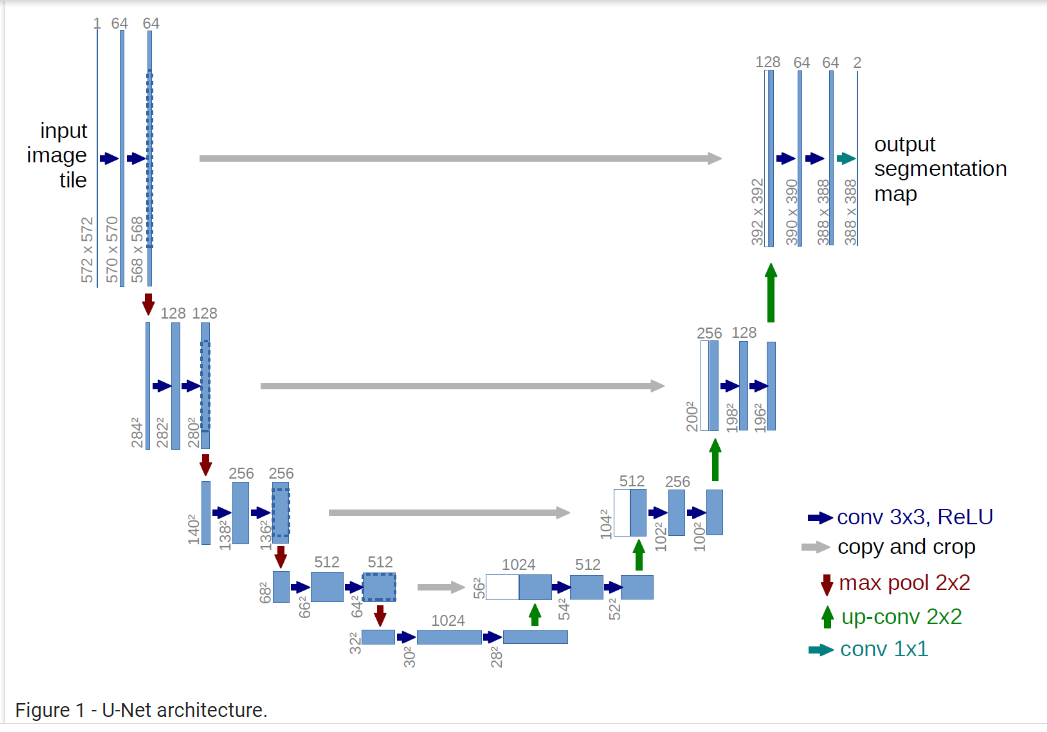

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import numpy as np

# Assuming you have your stacked images data in numpy arrays train_data and test_data

# Define your model architecture
input_img = Input(shape=(height, width, channels))  # adjust the input shape according to your data
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 64)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Normalize data
train_data = train_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

# Train the model
autoencoder.fit(train_data, train_data,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(test_data, test_data))

# Evaluate the model
train_loss = autoencoder.evaluate(train_data, train_data, verbose=0)
print("Training Loss:", train_loss)
test_loss = autoencoder.evaluate(test_data, test_data, verbose=0)
print("Testing Loss:", test_loss)
